In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

Using TensorFlow backend.


In [2]:
imagedir = "Dataset_4850"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 4850
Label: 1	Family:              PG	Number of images: 4850
Processing images ...
Images processed: 9700


In [4]:
X.shape

(9700, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
# Adding the top layer
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=200
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-resnet50-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [11]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

1940/1940 [==============================] - 9s     
[0] Initial acurracy: 0.4876
Train on 7760 samples, validate on 1940 samples
Epoch 1/200
7760/7760 [==============================] - 92s - loss: 0.5798 - acc: 0.7589 - val_loss: 8.0606 - val_acc: 0.4995
Epoch 2/200
7760/7760 [==============================] - 84s - loss: 0.3998 - acc: 0.8250 - val_loss: 0.9358 - val_acc: 0.7665
Epoch 3/200
7760/7760 [==============================] - 83s - loss: 0.3933 - acc: 0.8293 - val_loss: 7.8923 - val_acc: 0.4969
Epoch 4/200
7760/7760 [==============================] - 83s - loss: 0.3064 - acc: 0.8713 - val_loss: 3.1742 - val_acc: 0.6907
Epoch 5/200
7760/7760 [==============================] - 83s - loss: 0.2540 - acc: 0.8957 - val_loss: 2.4577 - val_acc: 0.7088
Epoch 6/200
7760/7760 [==============================] - 84s - loss: 0.2034 - acc: 0.9213 - val_loss: 1.4278 - val_acc: 0.6222
Epoch 7/200
7760/7760 [==============================] - 84s - loss: 0.1876 - acc: 0.9253 - val_loss: 0.9222

7760/7760 [==============================] - 84s - loss: 0.0145 - acc: 0.9951 - val_loss: 0.6072 - val_acc: 0.8639
Epoch 65/200
7760/7760 [==============================] - 83s - loss: 0.0058 - acc: 0.9986 - val_loss: 0.6054 - val_acc: 0.8727
Epoch 66/200
7760/7760 [==============================] - 84s - loss: 0.0061 - acc: 0.9985 - val_loss: 0.8018 - val_acc: 0.8546
Epoch 67/200
7760/7760 [==============================] - 84s - loss: 0.0064 - acc: 0.9985 - val_loss: 0.8913 - val_acc: 0.8258
Epoch 68/200
7760/7760 [==============================] - 84s - loss: 0.0103 - acc: 0.9968 - val_loss: 0.7828 - val_acc: 0.8546
Epoch 69/200
7760/7760 [==============================] - 84s - loss: 0.0091 - acc: 0.9966 - val_loss: 1.0880 - val_acc: 0.8407
Epoch 70/200
7760/7760 [==============================] - 84s - loss: 0.0297 - acc: 0.9888 - val_loss: 2.1038 - val_acc: 0.7000
Epoch 71/200
7760/7760 [==============================] - 83s - loss: 0.0243 - acc: 0.9923 - val_loss: 0.7345 - val_a

7760/7760 [==============================] - 84s - loss: 0.0246 - acc: 0.9928 - val_loss: 0.9165 - val_acc: 0.7985
Epoch 190/200
7760/7760 [==============================] - 84s - loss: 0.0182 - acc: 0.9945 - val_loss: 0.7804 - val_acc: 0.8361
Epoch 191/200
7760/7760 [==============================] - 84s - loss: 0.0048 - acc: 0.9982 - val_loss: 1.7529 - val_acc: 0.7613
Epoch 192/200
7760/7760 [==============================] - 84s - loss: 0.0031 - acc: 0.9992 - val_loss: 1.3780 - val_acc: 0.7892
Epoch 193/200
7760/7760 [==============================] - 84s - loss: 0.0077 - acc: 0.9970 - val_loss: 0.8396 - val_acc: 0.8335
Epoch 194/200
7760/7760 [==============================] - 84s - loss: 0.0113 - acc: 0.9966 - val_loss: 1.0827 - val_acc: 0.8541
Epoch 195/200
7760/7760 [==============================] - 84s - loss: 0.0144 - acc: 0.9947 - val_loss: 1.0788 - val_acc: 0.8211
Epoch 196/200
7760/7760 [==============================] - 84s - loss: 0.0034 - acc: 0.9987 - val_loss: 0.9536 

7760/7760 [==============================] - 84s - loss: 0.0110 - acc: 0.9963 - val_loss: 0.9432 - val_acc: 0.8211
Epoch 115/200
7760/7760 [==============================] - 84s - loss: 0.0049 - acc: 0.9986 - val_loss: 0.8341 - val_acc: 0.8376
Epoch 116/200
7760/7760 [==============================] - 84s - loss: 0.0116 - acc: 0.9956 - val_loss: 2.0540 - val_acc: 0.7335
Epoch 117/200
7760/7760 [==============================] - 83s - loss: 0.0070 - acc: 0.9966 - val_loss: 0.9014 - val_acc: 0.8299
Epoch 118/200
7760/7760 [==============================] - 84s - loss: 0.0084 - acc: 0.9976 - val_loss: 1.0187 - val_acc: 0.8144
Epoch 119/200
7760/7760 [==============================] - 84s - loss: 0.0256 - acc: 0.9907 - val_loss: 1.1837 - val_acc: 0.7959
Epoch 120/200
7760/7760 [==============================] - 84s - loss: 0.0215 - acc: 0.9925 - val_loss: 1.1955 - val_acc: 0.8010
Epoch 121/200
7760/7760 [==============================] - 84s - loss: 0.0433 - acc: 0.9853 - val_loss: 0.8816 

7760/7760 [==============================] - 85s - loss: 0.2116 - acc: 0.9164 - val_loss: 1.4865 - val_acc: 0.6510
Epoch 40/200
7760/7760 [==============================] - 84s - loss: 0.2044 - acc: 0.9175 - val_loss: 0.4763 - val_acc: 0.8149
Epoch 41/200
7760/7760 [==============================] - 84s - loss: 0.1929 - acc: 0.9222 - val_loss: 0.8065 - val_acc: 0.7433
Epoch 42/200
7760/7760 [==============================] - 84s - loss: 0.1716 - acc: 0.9293 - val_loss: 1.9873 - val_acc: 0.6077
Epoch 43/200
7760/7760 [==============================] - 84s - loss: 0.1546 - acc: 0.9433 - val_loss: 0.5524 - val_acc: 0.8113
Epoch 44/200
7760/7760 [==============================] - 84s - loss: 0.1244 - acc: 0.9505 - val_loss: 2.5527 - val_acc: 0.6149
Epoch 45/200
7760/7760 [==============================] - 84s - loss: 0.1177 - acc: 0.9568 - val_loss: 1.0807 - val_acc: 0.7320
Epoch 46/200
7760/7760 [==============================] - 84s - loss: 0.1115 - acc: 0.9577 - val_loss: 1.0700 - val_a

7760/7760 [==============================] - 84s - loss: 0.0118 - acc: 0.9965 - val_loss: 0.9968 - val_acc: 0.8026
Epoch 104/200
7760/7760 [==============================] - 84s - loss: 0.0105 - acc: 0.9970 - val_loss: 0.8674 - val_acc: 0.8294
Epoch 105/200
7760/7760 [==============================] - 84s - loss: 0.0070 - acc: 0.9981 - val_loss: 0.8225 - val_acc: 0.8371
Epoch 106/200
7760/7760 [==============================] - 83s - loss: 0.0276 - acc: 0.9899 - val_loss: 0.9754 - val_acc: 0.7943
Epoch 107/200
7760/7760 [==============================] - 83s - loss: 0.0467 - acc: 0.9836 - val_loss: 1.4646 - val_acc: 0.7366
Epoch 108/200
7760/7760 [==============================] - 84s - loss: 0.0110 - acc: 0.9969 - val_loss: 2.6744 - val_acc: 0.6701
Epoch 109/200
7760/7760 [==============================] - 84s - loss: 0.0066 - acc: 0.9985 - val_loss: 1.8530 - val_acc: 0.7443
Epoch 110/200
7760/7760 [==============================] - 84s - loss: 0.0404 - acc: 0.9871 - val_loss: 0.8754 

7760/7760 [==============================] - 84s - loss: 0.3348 - acc: 0.8550 - val_loss: 0.5488 - val_acc: 0.7593
Epoch 29/200
7760/7760 [==============================] - 84s - loss: 0.3220 - acc: 0.8606 - val_loss: 0.8006 - val_acc: 0.7134
Epoch 30/200
7760/7760 [==============================] - 84s - loss: 0.2961 - acc: 0.8755 - val_loss: 0.4509 - val_acc: 0.8119
Epoch 31/200
7760/7760 [==============================] - 84s - loss: 0.2716 - acc: 0.8872 - val_loss: 0.4798 - val_acc: 0.7928
Epoch 32/200
7760/7760 [==============================] - 84s - loss: 0.2671 - acc: 0.8918 - val_loss: 0.4948 - val_acc: 0.7907
Epoch 33/200
7760/7760 [==============================] - 84s - loss: 0.2494 - acc: 0.8990 - val_loss: 0.5383 - val_acc: 0.7912
Epoch 34/200
7760/7760 [==============================] - 84s - loss: 0.2315 - acc: 0.9028 - val_loss: 0.8066 - val_acc: 0.7351
Epoch 35/200
7760/7760 [==============================] - 84s - loss: 0.1913 - acc: 0.9241 - val_loss: 0.5822 - val_a

7760/7760 [==============================] - 84s - loss: 0.0220 - acc: 0.9927 - val_loss: 1.7431 - val_acc: 0.7299
Epoch 156/200
7760/7760 [==============================] - 84s - loss: 0.0112 - acc: 0.9964 - val_loss: 1.1795 - val_acc: 0.7804
Epoch 157/200
7760/7760 [==============================] - 84s - loss: 0.0096 - acc: 0.9972 - val_loss: 1.4043 - val_acc: 0.7479
Epoch 158/200
7760/7760 [==============================] - 84s - loss: 0.0096 - acc: 0.9970 - val_loss: 1.3043 - val_acc: 0.7861
Epoch 159/200
7760/7760 [==============================] - 84s - loss: 0.0367 - acc: 0.9876 - val_loss: 1.3101 - val_acc: 0.7485
Epoch 160/200
7760/7760 [==============================] - 84s - loss: 0.0063 - acc: 0.9979 - val_loss: 1.1342 - val_acc: 0.7943
Epoch 161/200
7760/7760 [==============================] - 83s - loss: 0.0028 - acc: 0.9995 - val_loss: 1.1606 - val_acc: 0.7979
Epoch 162/200
7760/7760 [==============================] - 84s - loss: 0.0016 - acc: 0.9996 - val_loss: 1.8769 

7760/7760 [==============================] - 84s - loss: 0.6034 - acc: 0.7524 - val_loss: 0.6861 - val_acc: 0.6851
Epoch 18/200
7760/7760 [==============================] - 85s - loss: 0.6573 - acc: 0.7622 - val_loss: 0.6565 - val_acc: 0.6964
Epoch 19/200
7760/7760 [==============================] - 84s - loss: 0.6065 - acc: 0.7528 - val_loss: 1.1856 - val_acc: 0.6526
Epoch 20/200
7760/7760 [==============================] - 84s - loss: 0.5869 - acc: 0.7581 - val_loss: 0.6463 - val_acc: 0.6845
Epoch 21/200
7760/7760 [==============================] - 84s - loss: 0.6361 - acc: 0.7594 - val_loss: 0.6050 - val_acc: 0.6814
Epoch 22/200
7760/7760 [==============================] - 84s - loss: 0.7777 - acc: 0.6552 - val_loss: 0.6442 - val_acc: 0.6284
Epoch 23/200
7760/7760 [==============================] - 84s - loss: 0.6039 - acc: 0.7024 - val_loss: 0.6444 - val_acc: 0.6778
Epoch 24/200
7760/7760 [==============================] - 84s - loss: 0.5589 - acc: 0.7271 - val_loss: 0.5551 - val_a

7760/7760 [==============================] - 83s - loss: 0.0049 - acc: 0.9985 - val_loss: 1.5612 - val_acc: 0.7510
Epoch 145/200
7760/7760 [==============================] - 84s - loss: 0.0050 - acc: 0.9985 - val_loss: 1.0736 - val_acc: 0.8046
Epoch 146/200
7760/7760 [==============================] - 84s - loss: 0.0141 - acc: 0.9968 - val_loss: 0.9970 - val_acc: 0.8093
Epoch 147/200
7760/7760 [==============================] - 84s - loss: 0.0557 - acc: 0.9820 - val_loss: 2.3819 - val_acc: 0.6943
Epoch 148/200
7760/7760 [==============================] - 84s - loss: 0.0302 - acc: 0.9896 - val_loss: 1.1677 - val_acc: 0.7876
Epoch 149/200
7760/7760 [==============================] - 84s - loss: 0.0276 - acc: 0.9910 - val_loss: 1.0222 - val_acc: 0.7974
Epoch 150/200
7760/7760 [==============================] - 84s - loss: 0.0176 - acc: 0.9943 - val_loss: 0.9425 - val_acc: 0.8093
Epoch 151/200
7760/7760 [==============================] - 84s - loss: 0.0053 - acc: 0.9985 - val_loss: 0.9263 

In [12]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8212


In [13]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

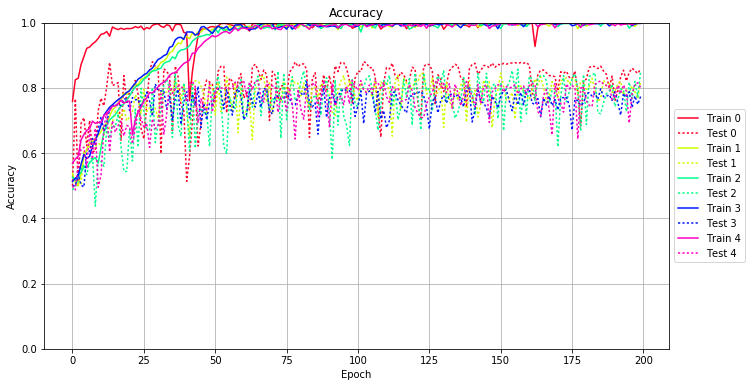

In [14]:
plot_acc(history)

In [15]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

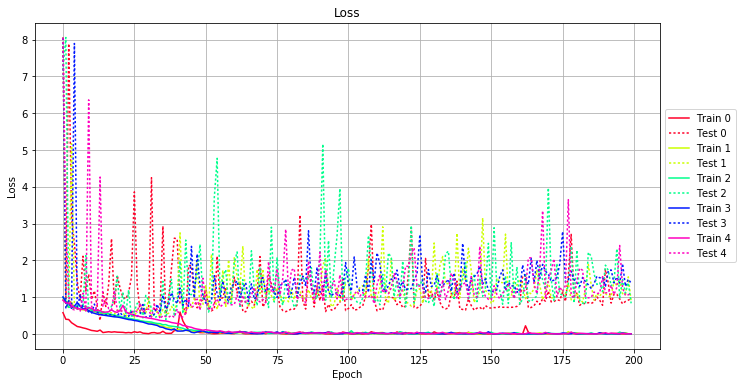

In [16]:
plot_loss(history)

Plotting the confusion matrix


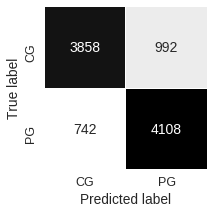

In [17]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


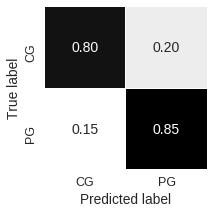

In [18]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
for h in history:
    print(h.history)

{'acc': [0.75889175257731956, 0.82499999999999996, 0.82925257731958768, 0.87126288659793816, 0.89574742268041241, 0.92126288659793809, 0.92525773195876293, 0.9347938144329897, 0.94123711340206184, 0.95167525773195871, 0.96430412371134022, 0.96636597938144331, 0.97255154639175256, 0.95850515463917529, 0.98659793814432994, 0.98195876288659789, 0.97873711340206182, 0.98298969072164943, 0.97938144329896903, 0.98221649484536078, 0.98144329896907212, 0.98298969072164943, 0.98788659793814437, 0.98440721649484542, 0.9891752577319588, 0.97847938144329893, 0.98492268041237119, 0.98144329896907212, 0.99175257731958766, 0.99497422680412373, 0.99652061855670104, 0.98878865979381447, 0.9855670103092784, 0.99355670103092786, 0.990979381443299, 0.97461340206185565, 0.99317010309278353, 0.99561855670103094, 0.99239690721649487, 0.97023195876288659, 0.96623711340206186, 0.76095360824742264, 0.85012886597938142, 0.91056701030927834, 0.95927835051546395, 0.97899484536082471, 0.98105670103092779, 0.9813144

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

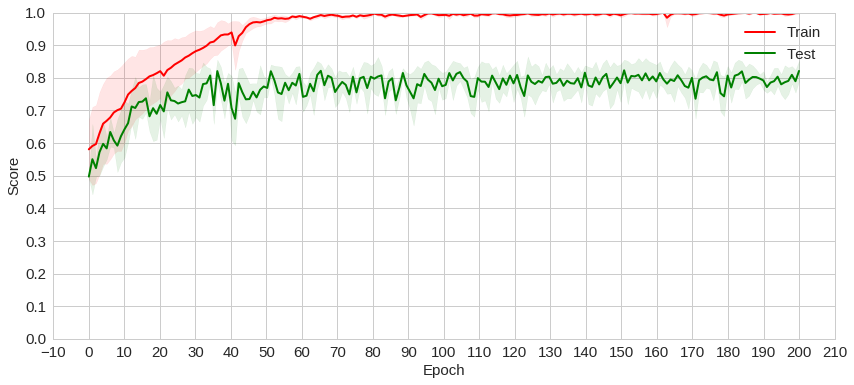

In [21]:
plot_mean_acc(history)

In [22]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

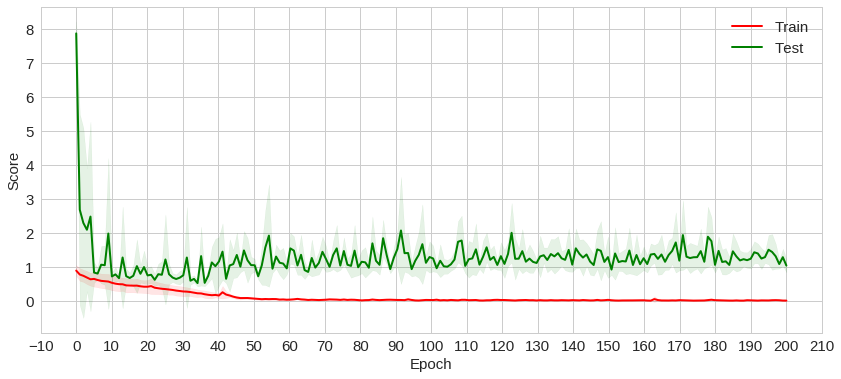

In [23]:
plot_mean_loss(history)

In [1]:
history= [{'acc': [0.75889175257731956, 0.82499999999999996, 0.82925257731958768, 0.87126288659793816, 0.89574742268041241, 0.92126288659793809, 0.92525773195876293, 0.9347938144329897, 0.94123711340206184, 0.95167525773195871, 0.96430412371134022, 0.96636597938144331, 0.97255154639175256, 0.95850515463917529, 0.98659793814432994, 0.98195876288659789, 0.97873711340206182, 0.98298969072164943, 0.97938144329896903, 0.98221649484536078, 0.98144329896907212, 0.98298969072164943, 0.98788659793814437, 0.98440721649484542, 0.9891752577319588, 0.97847938144329893, 0.98492268041237119, 0.98144329896907212, 0.99175257731958766, 0.99497422680412373, 0.99652061855670104, 0.98878865979381447, 0.9855670103092784, 0.99355670103092786, 0.990979381443299, 0.97461340206185565, 0.99317010309278353, 0.99561855670103094, 0.99239690721649487, 0.97023195876288659, 0.96623711340206186, 0.76095360824742264, 0.85012886597938142, 0.91056701030927834, 0.95927835051546395, 0.97899484536082471, 0.98105670103092779, 0.98131443298969068, 0.98608247422680417, 0.9882731958762887, 0.9855670103092784, 0.98969072164948457, 0.99703608247422681, 0.99768041237113403, 0.99716494845360826, 0.99355670103092786, 0.9918814432989691, 0.99033505154639179, 0.99342783505154642, 0.9954896907216495, 0.99613402061855671, 0.98453608247422686, 0.97409793814432988, 0.99510309278350517, 0.99858247422680413, 0.99845360824742269, 0.99845360824742269, 0.99677835051546393, 0.99664948453608249, 0.98878865979381447, 0.99226804123711343, 0.99742268041237114, 0.99136597938144333, 0.98878865979381447, 0.99329896907216497, 0.98492268041237119, 0.99510309278350517, 0.99961340206185567, 1.0, 0.99948453608247423, 1.0, 1.0, 0.99974226804123711, 0.99226804123711343, 0.98389175257731953, 0.99304123711340209, 0.99574742268041239, 0.99239690721649487, 0.98801546391752582, 0.9936855670103093, 0.99072164948453612, 0.99561855670103094, 0.99922680412371134, 0.99987113402061856, 1.0, 1.0, 0.99935567010309279, 0.99677835051546393, 0.98273195876288655, 0.98698453608247427, 0.99755154639175259, 0.99948453608247423, 1.0, 0.99987113402061856, 0.99948453608247423, 0.99987113402061856, 0.99871134020618557, 0.99523195876288661, 0.98041237113402058, 0.98775773195876293, 0.9972938144329897, 0.99845360824742269, 0.99948453608247423, 0.99987113402061856, 0.99987113402061856, 0.99935567010309279, 0.99871134020618557, 0.98118556701030923, 0.9936855670103093, 0.99884020618556701, 0.99845360824742269, 0.98943298969072169, 0.99523195876288661, 0.99935567010309279, 0.99948453608247423, 0.99884020618556701, 0.99832474226804124, 0.99793814432989691, 0.99832474226804124, 0.99922680412371134, 0.97963917525773192, 0.99085051546391756, 0.99832474226804124, 0.99961340206185567, 1.0, 1.0, 0.99948453608247423, 0.99213917525773199, 0.99162371134020622, 0.98672680412371139, 0.99845360824742269, 0.99987113402061856, 0.98440721649484542, 0.99677835051546393, 0.99961340206185567, 0.99948453608247423, 1.0, 0.99987113402061856, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99922680412371134, 0.92693298969072169, 0.98376288659793809, 0.99845360824742269, 0.99974226804123711, 0.99974226804123711, 0.99755154639175259, 0.99793814432989691, 0.99948453608247423, 0.99922680412371134, 0.99884020618556701, 0.9981958762886598, 0.99768041237113403, 0.99832474226804124, 0.99858247422680413, 0.99858247422680413, 0.99626288659793816, 0.98724226804123716, 0.99780927835051547, 0.99948453608247423, 1.0, 0.99987113402061856, 1.0, 0.99987113402061856, 1.0, 0.99948453608247423, 0.99935567010309279, 0.9927835051546392, 0.99445876288659796, 0.9981958762886598, 0.99922680412371134, 0.99703608247422681, 0.99664948453608249, 0.99471649484536084, 0.99871134020618557, 0.99948453608247423, 0.99974226804123711, 0.99974226804123711, 0.99896907216494846], 'loss': [0.57979045835966914, 0.39983800133479008, 0.3933298575816695, 0.30638277960806776, 0.25397040555157613, 0.20339938002763336, 0.18758287918321864, 0.16563694255868183, 0.1479514130304769, 0.12285278651517691, 0.096213011090288458, 0.086399320221131615, 0.073000482208642761, 0.105924653300305, 0.038456532316877672, 0.050244102907395852, 0.060645898838633118, 0.048976254574570458, 0.059174759683112817, 0.049294091526841381, 0.047545758062570366, 0.043701718864751229, 0.032586640543928465, 0.040106383973214123, 0.031308772929550449, 0.060756349092176587, 0.041666547114932048, 0.057072602945965591, 0.023146842531955886, 0.016338098709970789, 0.0086884361356928865, 0.034345354919427452, 0.038672265692700429, 0.019697879649909961, 0.02668370896273475, 0.0731313803914896, 0.020136928358643325, 0.015953246459662531, 0.020177165908047679, 0.092011277992086318, 0.10018077910368897, 0.59624247538674735, 0.35261310240657057, 0.21722873178953978, 0.11272048780444971, 0.057529520105148099, 0.052426316366367735, 0.053559021125595595, 0.037784283168460289, 0.035189068802757205, 0.040125197433319292, 0.031162154229991523, 0.010517272332049523, 0.0062525250056048032, 0.0097990113473737355, 0.016293913244507418, 0.024467153120401902, 0.02921416887859862, 0.019333728992850664, 0.01117914055675729, 0.010158556144439721, 0.045036290004158146, 0.075018137340078644, 0.014474019119227978, 0.0057825116697487605, 0.006087845275100541, 0.006352400549413809, 0.010324933104272259, 0.0090789350176940561, 0.029665750444905121, 0.024299480376726728, 0.0087292659878922801, 0.028234595799405782, 0.031881086841782501, 0.019100880971149609, 0.046000175607707541, 0.014729811875965716, 0.0027342713286154473, 0.00075994583069390054, 0.0020210376623225851, 0.00045676575921123043, 0.00034428854716642273, 0.00063689011170111178, 0.022144181342761287, 0.045924085048363379, 0.01990996335054623, 0.013207729939208126, 0.021385437731400669, 0.031804400366567766, 0.018391700207073355, 0.027533502686893585, 0.014639143796623252, 0.0040648859754545599, 0.00098016618312331705, 0.00067764055419661652, 0.00038511516438504876, 0.0017694166646046161, 0.0090907977981635104, 0.052034167317462333, 0.035068731126015447, 0.007413554901602803, 0.0030765484632190904, 0.00078890248145980124, 0.0006708074846999844, 0.0014063069504849522, 0.00080993894499846008, 0.0040230204874815269, 0.017103179342403872, 0.060308160430262076, 0.031345840048083322, 0.011583097630845605, 0.005482726933112963, 0.0023885939545094121, 0.0014032150524636779, 0.00051995114951104064, 0.0017700413645160523, 0.0031227322280756196, 0.056726797182381765, 0.018101578661883923, 0.0043392146880541615, 0.0050474448946842294, 0.033800724493075626, 0.014095703776945004, 0.0038697456537905516, 0.0020073315565654055, 0.0031197769231026146, 0.0042404682968968776, 0.0052473207638351746, 0.0039972646348238397, 0.0033713257912973654, 0.057874625544639825, 0.022996463016462847, 0.0051741810882771294, 0.0018835675871760593, 0.00040510318209909229, 0.00056352395945817916, 0.0013395530365517881, 0.021214677225714358, 0.027459133763499941, 0.036775576440886276, 0.0059374160841395409, 0.001539512036833912, 0.047265487010338697, 0.011363070081324153, 0.0016690697377852461, 0.0017845559818130082, 0.00074550977836215402, 0.00053461863751284367, 0.00030831519999486136, 0.00017872424769220088, 0.00012801102265510371, 0.00021733547740969352, 0.00011063236909546138, 8.7206480256353056e-05, 6.3027729747679498e-05, 4.5731337767270797e-05, 9.9745944898291109e-05, 6.720530285391075e-05, 3.9719050501028588e-05, 4.909376369601118e-05, 0.00024934392837148501, 0.0020992227021526992, 0.22202046528823444, 0.047076812507488679, 0.012842816816278033, 0.0020726932421031548, 0.0011121248679065155, 0.010081824608994455, 0.0058859781747142015, 0.0025955867965750099, 0.0027253817826312652, 0.0044850458273695323, 0.0054425649750124445, 0.0070838527866613991, 0.0054560125620613242, 0.0038193741290633251, 0.0044591187389349069, 0.011568181920684418, 0.039107113814259853, 0.0080609671074834636, 0.0021292206268702374, 0.00092618664566543882, 0.001142150382589328, 0.00037384299911789957, 0.00052548867668369937, 0.00017292233654648184, 0.0018077766070924441, 0.0021277102865365732, 0.024624095016530265, 0.018161571602194244, 0.0048460873274118205, 0.0030645173058764692, 0.0076743539419975105, 0.011337298481873976, 0.014357645167085851, 0.0033681176882177188, 0.0012566653550526172, 0.00094451975838478336, 0.0013264898772419103, 0.003325634104993762], 'val_acc': [0.49948453608247423, 0.76649484511503241, 0.49690721649484537, 0.69072164936163993, 0.70876288672083432, 0.62216494848433224, 0.70000000024579234, 0.60515463919061974, 0.60515463920598178, 0.72989690727794299, 0.76855670103092788, 0.74484536070184615, 0.80463917574931665, 0.8778350514234956, 0.80721649533694551, 0.81134020618556701, 0.81597938193488362, 0.63969072171093266, 0.83762886573358908, 0.75567010321567973, 0.78711340181606337, 0.78556701067796686, 0.82268041286271876, 0.77989690721649485, 0.67628865979381447, 0.6438144331125869, 0.74793814445279305, 0.85309278325936233, 0.87989690697070244, 0.86494845385403973, 0.85979381467878202, 0.59845360827814675, 0.85876288684373048, 0.84999999987710384, 0.83814433014269951, 0.66546391752577316, 0.86701030903255816, 0.83298969084454566, 0.74742268053526728, 0.72886597950433951, 0.51340206185567006, 0.58969072164948455, 0.69896907191915614, 0.79639175257731953, 0.62164948453608249, 0.69020618562845837, 0.79020618568990653, 0.82422680461529607, 0.81804123760498682, 0.81082474202224886, 0.75721649496825705, 0.85051546367173347, 0.86597938156619514, 0.86597938168909128, 0.72319587616576364, 0.82989690733939103, 0.82010309266060899, 0.76701030927835057, 0.82216494894519299, 0.84329896931795734, 0.76855670127672016, 0.78556701055507072, 0.72938144354476142, 0.86391752589609205, 0.87268041237113403, 0.85463917550352431, 0.82577319636787339, 0.85463917513483578, 0.84072164936163996, 0.69999999993855189, 0.85051546367173347, 0.8381443303884919, 0.76494845366969555, 0.80567010358436819, 0.80721649472246459, 0.76597938144329902, 0.84845360812452653, 0.85876288647504195, 0.87938144305317667, 0.86494845348535121, 0.87371134008328943, 0.87319587616576366, 0.85670103068204273, 0.64845360837031885, 0.82731958787465831, 0.84639175257731958, 0.75257731958762886, 0.79123711327916568, 0.84020618581280271, 0.7865979378985376, 0.83814432965111485, 0.78453608247422679, 0.86752577319587632, 0.84999999999999998, 0.8778350514234956, 0.87731958787465836, 0.85979381467878202, 0.82319587678024453, 0.75360824729978426, 0.83041237088822828, 0.85154639162968115, 0.84948453608247421, 0.88041237101112446, 0.87525773220455527, 0.86134020593977467, 0.86237113389772235, 0.83608247422680415, 0.73505154639175263, 0.64896907216494848, 0.81391752601898826, 0.86237113426641088, 0.85824742243462004, 0.87577319563049627, 0.83865979430601767, 0.82938144317607287, 0.84793814445279303, 0.84072164936163996, 0.82061855645523862, 0.8252577318358667, 0.86340206160987776, 0.85824742292620471, 0.75257731983342124, 0.70670103092783509, 0.86443298956782544, 0.87319587653445219, 0.8711340208643491, 0.85257731958762883, 0.7515463919983697, 0.84020618532121794, 0.82680412371134016, 0.78865979356864069, 0.81134020569398235, 0.8525773194647327, 0.86237113377482622, 0.87216494833071212, 0.86804123735919436, 0.83041237064243589, 0.82422680461529607, 0.74072164973032839, 0.85721649472246464, 0.87268041224823789, 0.87525773183586675, 0.84278350564622384, 0.85257731983342122, 0.86855670078513547, 0.86855670090803161, 0.86134020643135933, 0.87628865954802204, 0.86288659769235199, 0.87216494845360826, 0.87010309266060903, 0.8752577317129705, 0.87268041224823789, 0.87577319587628866, 0.87628865954802204, 0.87731958738307358, 0.87474226779544473, 0.87783505154639174, 0.87577319575339252, 0.8778350514234956, 0.86958762874308315, 0.78711340193895951, 0.7634020619785663, 0.8417525778111723, 0.85463917550352431, 0.85463917501193964, 0.84639175257731958, 0.83762886597938147, 0.83711340230764797, 0.83402061880249334, 0.79020618568990653, 0.84948453620537046, 0.84484536107053465, 0.85103092795794777, 0.8324742266812275, 0.82783505130059942, 0.85154639199836968, 0.78556701030927834, 0.68350515476207141, 0.81855670103092781, 0.82731958750596979, 0.86237113389772235, 0.86701030903255816, 0.86494845336245507, 0.85927835026967159, 0.86649484511503239, 0.85154639199836968, 0.84175257707379525, 0.79845360873900739, 0.83608247447259643, 0.76134020643135936, 0.78917525810064726, 0.83350515488496757, 0.85412371109441387, 0.82113402074145292, 0.84742268065816351, 0.86030927810472313, 0.85206185591589545, 0.84432989703011263, 0.85773195851709427], 'val_loss': [8.060631669139859, 0.93581801443984824, 7.8923357521366215, 3.1742273114391208, 2.4576799871380794, 1.4277565103523511, 0.92222582212428461, 2.1139343194125852, 1.1667643987640892, 1.6250772017793558, 0.93743096958730643, 1.1733938146805025, 0.74885898226315217, 0.36651736835843507, 1.1347356031850442, 0.74704977860002175, 1.3448729387263663, 2.5887905297512859, 0.79128888473682801, 1.5982462641043762, 1.239915564871326, 1.0004352745014367, 0.95044305570346788, 1.1256353369078684, 1.5586144426741551, 3.8629307993484598, 1.3387058325649537, 0.61348233898890392, 0.57972204304233044, 0.66639830973959457, 0.70338379574805188, 4.2468763341618336, 0.62548035877881591, 0.66761368927881892, 0.67578654790047521, 2.9296712526341073, 0.55144524187156829, 0.95890458564168402, 1.7777162877631556, 2.6044305974675206, 2.5829997937703868, 0.8214320740748926, 0.78680901539694403, 0.51304973572799839, 1.863793434832514, 1.8471300554644201, 1.0048040016410278, 0.71112458583005922, 0.88350700127709769, 0.92079316190223104, 1.2022237374610507, 0.73295833253368892, 0.62926311910766919, 0.67734947167720994, 2.117302457577328, 0.94676234427186634, 0.9862726188504819, 1.2687104507819893, 0.92100375067327445, 0.96498050308719119, 1.5443028754794721, 1.1140314829718205, 1.423522234208805, 0.60723881537152324, 0.60539843495359125, 0.80183865421826073, 0.89126344734860452, 0.78281079198896275, 1.0880316395120522, 2.103768054403595, 0.73445636058591079, 0.87394151269775078, 1.6052017483514609, 1.3568528336347994, 1.1220740988082492, 1.2022090736123705, 0.73940847445394575, 0.63669739078307885, 0.60688328853587514, 0.63430113982908509, 0.6842498299080072, 0.67532004912182231, 0.79053722165294527, 3.2317505902082648, 0.90555134458640185, 0.67702610873684443, 1.7156501204658723, 1.3118183730803814, 0.73569101365571166, 1.3086670659252049, 0.90178409642779955, 1.3136226123141259, 0.60899001568863076, 0.80576119651038625, 0.64923577112020903, 0.66401631801398764, 0.7856233720926894, 0.84508398660679451, 1.4881396671085014, 0.6369478188839155, 0.69394181075784345, 0.7970082713156631, 0.64799033639971748, 0.66554402137540047, 0.72732278784525761, 0.76482233186972515, 1.0267964862056613, 1.8305304959877251, 2.9814948622943813, 0.93361949281594192, 0.63013368279663562, 0.67892351986206689, 0.64996617556232772, 0.90390809590054544, 1.0145170979969895, 0.99399883108040721, 0.97902370875643696, 0.79636526670038088, 0.8775132540575008, 0.7125592299343384, 0.76406781802472379, 1.6845505984788089, 2.8927341544751037, 0.71999929123318074, 0.7080391982167038, 0.75542162841128324, 0.85756952824051846, 2.0543697298187569, 0.99266248763222054, 1.1594169263526337, 0.92745724781272343, 1.1513751462562798, 0.86286374751440031, 0.7233723044395447, 0.68319906653817164, 0.7068576421934305, 1.1062697218865463, 0.96969364402220426, 1.4359857903927873, 0.68499018599077599, 0.66670150083979385, 0.64770774401954767, 0.95409767283606772, 0.77242188822362845, 0.64926852196762241, 0.70134355407400228, 0.7248941840584745, 0.65811839902523872, 0.7702187957222929, 0.71099051604258645, 0.70463997297680259, 0.7187159484501966, 0.71481766576312256, 0.73889936006714385, 0.72636045265136306, 0.72723132288947545, 0.72319327045961757, 0.72485624921997793, 0.72976534423447148, 0.7493248061881852, 0.81533998090428172, 1.5769709791796109, 1.5798555307781574, 0.71026390557436603, 0.72054497138741092, 0.76944526298758908, 0.89170083569497183, 0.80328082989171612, 0.956070829728215, 0.88934399534746544, 1.1636056865613484, 0.87245453559246255, 0.88505716956767844, 0.93284926734019802, 0.91157824501548845, 1.1399069813723417, 0.88533140863339921, 1.5932363613364622, 2.7085830964992956, 1.0863355892220723, 1.1097533014170902, 0.77953809235513827, 0.83811797425918977, 0.82176698900989653, 0.852194962304892, 0.82864888931058112, 0.86939252160259128, 1.0090016770608647, 0.91653613749238638, 0.7803569103024669, 1.752884854238058, 1.3779558120314608, 0.83964728817497336, 1.0826904757735656, 1.0788428756379589, 0.95359117179801789, 0.81881455244477264, 0.88349865871606414, 0.92004845437315319, 0.96155047723927445]}, 
{'acc': [0.53762886597938142, 0.50927835051546388, 0.50296391752577319, 0.53505154639175256, 0.59123711340206186, 0.61134020618556706, 0.63273195876288657, 0.63621134020618553, 0.64561855670103097, 0.65335051546391754, 0.66559278350515461, 0.68286082474226806, 0.69188144329896906, 0.71288659793814435, 0.73260309278350511, 0.74201030927835054, 0.75399484536082473, 0.7644329896907216, 0.78286082474226804, 0.77963917525773196, 0.79523195876288655, 0.80064432989690726, 0.81198453608247423, 0.80966494845360826, 0.82615979381443294, 0.82963917525773201, 0.83659793814432992, 0.84664948453608246, 0.85090206185567008, 0.86043814432989696, 0.86533505154639179, 0.87783505154639174, 0.88234536082474224, 0.89136597938144335, 0.90734536082474226, 0.91249999999999998, 0.9275773195876289, 0.93737113402061856, 0.93518041237113403, 0.95425257731958768, 0.95760309278350519, 0.95051546391752573, 0.96881443298969072, 0.96030927835051549, 0.97177835051546391, 0.97139175257731958, 0.98028350515463913, 0.98208762886597933, 0.97384020618556699, 0.97976804123711336, 0.98079896907216491, 0.98608247422680417, 0.98865979381443303, 0.98170103092783501, 0.97538659793814431, 0.99201030927835054, 0.98054123711340202, 0.99110824742268044, 0.98969072164948457, 0.98943298969072169, 0.98788659793814437, 0.98788659793814437, 0.9891752577319588, 0.98350515463917521, 0.98363402061855665, 0.9936855670103093, 0.98363402061855665, 0.99523195876288661, 0.99677835051546393, 0.99677835051546393, 0.98930412371134024, 0.98891752577319592, 0.9873711340206186, 0.99239690721649487, 0.99484536082474229, 0.98582474226804129, 0.9918814432989691, 0.99600515463917527, 0.99407216494845363, 0.98376288659793809, 0.99420103092783507, 0.99123711340206189, 0.990979381443299, 0.97976804123711336, 0.99600515463917527, 0.9918814432989691, 0.99523195876288661, 0.99703608247422681, 0.99085051546391756, 0.98969072164948457, 0.9936855670103093, 0.99613402061855671, 0.99265463917525776, 0.97822164948453605, 0.99523195876288661, 0.99832474226804124, 0.99871134020618557, 0.99742268041237114, 0.99677835051546393, 0.99884020618556701, 0.99523195876288661, 0.98711340206185572, 0.9927835051546392, 0.99394329896907219, 0.99716494845360826, 0.98363402061855665, 0.99780927835051547, 0.9954896907216495, 0.99703608247422681, 0.99690721649484537, 0.99677835051546393, 0.98762886597938149, 0.98711340206185572, 0.99626288659793816, 0.99858247422680413, 0.99561855670103094, 0.99664948453608249, 0.99755154639175259, 0.99072164948453612, 0.99252577319587632, 0.98530927835051552, 0.99523195876288661, 0.99935567010309279, 0.99974226804123711, 0.99793814432989691, 0.98853092783505159, 0.99162371134020622, 0.99536082474226806, 0.99845360824742269, 0.99574742268041239, 0.9972938144329897, 0.9990979381443299, 0.99884020618556701, 0.99690721649484537, 0.99162371134020622, 0.99394329896907219, 0.99871134020618557, 0.99793814432989691, 0.99703608247422681, 0.99677835051546393, 0.99780927835051547, 0.99845360824742269, 0.98788659793814437, 0.98775773195876293, 0.99793814432989691, 0.99871134020618557, 0.99755154639175259, 0.99896907216494846, 0.99085051546391756, 0.99304123711340209, 0.99832474226804124, 0.99626288659793816, 0.99871134020618557, 0.99677835051546393, 0.99793814432989691, 0.9954896907216495, 0.990979381443299, 0.99600515463917527, 0.99484536082474229, 0.99342783505154642, 0.9972938144329897, 0.9990979381443299, 0.99793814432989691, 0.99974226804123711, 0.9990979381443299, 0.99806701030927836, 0.99407216494845363, 0.98943298969072169, 0.99690721649484537, 0.99871134020618557, 0.99948453608247423, 0.99948453608247423, 1.0, 1.0, 0.99987113402061856, 0.99987113402061856, 0.99974226804123711, 0.98144329896907212, 0.99574742268041239, 0.99497422680412373, 0.98930412371134024, 0.99652061855670104, 0.99858247422680413, 0.99896907216494846, 0.99961340206185567, 0.9990979381443299, 0.99935567010309279, 0.99884020618556701, 0.99561855670103094, 0.99394329896907219, 0.9972938144329897, 0.9990979381443299, 0.99716494845360826, 0.99652061855670104, 0.99871134020618557, 0.99768041237113403, 0.99394329896907219, 0.98840206185567014, 0.9981958762886598, 0.99871134020618557], 'loss': [0.94209787870190809, 0.84563597059741458, 0.8992232339898335, 0.85790790700420894, 0.7172167578923333, 0.69034759752529185, 0.66434438916825755, 0.66355802853082868, 0.63845901894815194, 0.62876033094740402, 0.61972828796229407, 0.60416964710373244, 0.58775213784778246, 0.56844991728202587, 0.54857223181380443, 0.53354070960860889, 0.51903897831120438, 0.50840393931595318, 0.48144964864573525, 0.47556155698815572, 0.45561625613379725, 0.44996269793854549, 0.43149030995123167, 0.42414027735130072, 0.39782661383913964, 0.39059520935274888, 0.3814555921505407, 0.35971699473784141, 0.34646254728749853, 0.32563279264980982, 0.32098898506656137, 0.29374966805743186, 0.28472085478379555, 0.25787373867231544, 0.22864503762156693, 0.21195761051374612, 0.18313587065210046, 0.17006471636369055, 0.1611277631263143, 0.12214822415838536, 0.1108036020367416, 0.12996897059924822, 0.087776355921607652, 0.10800014708152751, 0.07833377666694602, 0.073443600297281419, 0.056321426713359109, 0.053309282556790669, 0.072913808582984296, 0.057162013319657021, 0.056308449674205681, 0.039595451778204172, 0.035360132059869695, 0.054738554634998757, 0.066013265351198377, 0.024751108161836247, 0.054427101582135123, 0.027809035851015258, 0.029705086813221888, 0.031314199552247207, 0.032846431109391769, 0.035402161568480056, 0.032958477834892488, 0.043882616801360221, 0.053564985778144343, 0.021243330555939181, 0.046112634202215785, 0.016204630382378231, 0.010452063396553864, 0.010890954840429051, 0.032706950662523201, 0.033104908689088428, 0.036772130147347551, 0.022340179734488892, 0.016144619061198739, 0.037914273112090592, 0.022859816924793663, 0.012058763004258543, 0.019104703452399712, 0.050923357334602432, 0.016861480004490191, 0.024758342136484906, 0.028522301053378694, 0.056151419140628933, 0.012479395357191026, 0.025194036133452943, 0.016347177835306172, 0.010359114606279073, 0.023640173969588712, 0.027380650723233011, 0.016843275836496086, 0.013328570280507322, 0.024444902684304326, 0.062604418849649346, 0.015762145708785535, 0.0064030560903664026, 0.0046660496889896807, 0.0073209774549618436, 0.010726441225257807, 0.0041622183785519377, 0.01580510796023744, 0.038150350588191419, 0.023162108458117725, 0.017389830501903732, 0.0092922975561826378, 0.047338720194073682, 0.0077282715696822277, 0.013967915172280609, 0.0091590306619614287, 0.0096795799334283873, 0.010059506670912708, 0.037640625975795629, 0.040561784178825076, 0.0110438977869842, 0.0048879320960079041, 0.011640976439710207, 0.0070384338942173982, 0.0084119462879187392, 0.025613332975214138, 0.021472077574772933, 0.04334583020656245, 0.013158328090458341, 0.0037735802224073945, 0.0018299912127573764, 0.0069877793815001348, 0.033907400633774926, 0.024912987001835533, 0.014973807645860829, 0.0055628057416845303, 0.011940551398456404, 0.0088056975626986788, 0.0029167570743215336, 0.0038156648506122381, 0.0098727338166953033, 0.028328430743110318, 0.017313107560609574, 0.0045457380092294754, 0.0060697748030526279, 0.0077687716802231702, 0.012044952691145021, 0.0060566080531307027, 0.0057976493332294998, 0.037361069910405872, 0.033283058227671157, 0.0062928491296485476, 0.0040209842851198253, 0.0065753681811422451, 0.0053684109949432412, 0.027978985043741838, 0.021287428479060799, 0.0077611168127715274, 0.01172506544047717, 0.004102784176009045, 0.0081194640898155333, 0.0061090254261741686, 0.014270046901812335, 0.025937358925080638, 0.012802586554472825, 0.013777990411659799, 0.019159918296938167, 0.0081217572970325412, 0.0023932921436144827, 0.0076386642482098119, 0.0022446913073433756, 0.002162118087919938, 0.0063550925564357513, 0.015627430433247803, 0.028243323741720741, 0.010151820575828021, 0.0054122995077536358, 0.0019139852939466418, 0.0017409424112387213, 0.00041087772444427044, 0.00025260639334182715, 0.00043149939677268492, 0.00048999292665349013, 0.00098374683201626857, 0.061213626888023745, 0.013599391361415272, 0.01376534747343856, 0.030176134332150373, 0.009699770709326894, 0.0039374681607311224, 0.0026250426018488782, 0.0014646953286257447, 0.0034985920031178146, 0.0024583947642351687, 0.0032954637123693079, 0.012230560222590227, 0.015192001108044143, 0.0085419430150518432, 0.0034174267837799336, 0.0071021227226964649, 0.01024720487460859, 0.0071102298761222312, 0.0073909561865370165, 0.020414455195699253, 0.033735710265086101, 0.0051849723797766784, 0.0037073407810332597], 'val_acc': [0.5, 0.5, 0.5, 0.50567010309278349, 0.6041237114631024, 0.60567010346147199, 0.62371134045197796, 0.6211340208643491, 0.61907216494845363, 0.62989690733939097, 0.62525773195876289, 0.65927835039256777, 0.65979381443298968, 0.67783505142349554, 0.69329896894926879, 0.72989690709359867, 0.72216494857650437, 0.70824742268041241, 0.73608247422680417, 0.69896907228784466, 0.71082474275962593, 0.72577319636787341, 0.77886597925854717, 0.76185567034888513, 0.72061855706971945, 0.79587628853689762, 0.72783505154639172, 0.73865979369153678, 0.72061855670103092, 0.73814432977401101, 0.70721649509115314, 0.79278350515463913, 0.78814432965111492, 0.78608247422680411, 0.80824742280330852, 0.78402061831090863, 0.82525773220455523, 0.79587628841400149, 0.76134020618556697, 0.81030927810472309, 0.73505154657609684, 0.65257731964907695, 0.80773195876288661, 0.82164948453608244, 0.82061855694682329, 0.8061855670103093, 0.78350515488496764, 0.71907216507134974, 0.81288659793814433, 0.80103092771215534, 0.71701030927835052, 0.81752577307298013, 0.72680412383423643, 0.75412371121731003, 0.83298969059875327, 0.77268041237113405, 0.72938144354476142, 0.81752577319587627, 0.66237113402061853, 0.8025773195876289, 0.7144329898136178, 0.73298969072164943, 0.7582474225575162, 0.64123711340206191, 0.79690721674063769, 0.80721649484536084, 0.83298969072164952, 0.83762886597938147, 0.75515463966684249, 0.8149484538540398, 0.72422680436950371, 0.75927835039256775, 0.77731958787465838, 0.75670103092783503, 0.82680412371134016, 0.79587628865979376, 0.78711340181606337, 0.82577319563049634, 0.81288659793814433, 0.81391752552740348, 0.77525773195876291, 0.81494845348535128, 0.7618556699801966, 0.74587628865979383, 0.80154639162968111, 0.80051546391752582, 0.77113402061855674, 0.81391752577319587, 0.80824742255751625, 0.78917525748616646, 0.78247422692701984, 0.72525773195876286, 0.7159793818119875, 0.79536082449647572, 0.81958762874308322, 0.83711340193895944, 0.78350515463917525, 0.82422680387791902, 0.80721649484536084, 0.77422680400081512, 0.76134020667715174, 0.81649484511503234, 0.79536082449647572, 0.78762886597938142, 0.79123711352495807, 0.77113402098724526, 0.82422680400081516, 0.71134020618556704, 0.81752577307298013, 0.81030927835051547, 0.81855670115382406, 0.78917525797775112, 0.65206185573155118, 0.82113402049566053, 0.83762886597938147, 0.73350515513075998, 0.82989690721649489, 0.81443298944492926, 0.79587628865979376, 0.8010309275892592, 0.81958762874308322, 0.81907216494845358, 0.84536082474226804, 0.84329896907216495, 0.78144329896907216, 0.79123711377075034, 0.82938144317607287, 0.78092783505154639, 0.78505154639175256, 0.81082474251383363, 0.67886597938144333, 0.81649484511503234, 0.76082474263672972, 0.73556701067796693, 0.79536082474226799, 0.76185567010309274, 0.80773195876288661, 0.82216494833071208, 0.69484536088619031, 0.82164948453608244, 0.75515463917525771, 0.79329896956374968, 0.71082474232948933, 0.75051546416331816, 0.82422680387791902, 0.80051546367173343, 0.81855670115382406, 0.67835051546391756, 0.77164948441318626, 0.79329896907216491, 0.8453608246193719, 0.80412371121730997, 0.76185567010309274, 0.76855670090803163, 0.78556701067796686, 0.70412371146310238, 0.80824742243462, 0.80515463942105003, 0.790206185321218, 0.77422680412371137, 0.76391752577319583, 0.79329896907216491, 0.82783505142349556, 0.80876288684373054, 0.83350515488496757, 0.80103092771215534, 0.75463917550352433, 0.77886597913565092, 0.81907216519424597, 0.7989690721649485, 0.77010309278350519, 0.82164948453608244, 0.82628865979381438, 0.83092783505154644, 0.81237113389772242, 0.82783505142349556, 0.82680412371134016, 0.77835051570970992, 0.82061855645523862, 0.81907216519424597, 0.79536082474226799, 0.80463917525773199, 0.82938144317607287, 0.79381443311258693, 0.75721649521404932, 0.76804123711340211, 0.82422680387791902, 0.80721649484536084, 0.8134020618556701, 0.78659793802143374, 0.78969072152658837, 0.81288659781524819, 0.82010309278350513, 0.77680412371134022, 0.79329896931795729, 0.78711340181606337, 0.8061855670103093, 0.78762886585648528, 0.76649484536082479, 0.82216494845360821], 'val_loss': [8.0590477500994258, 0.77279150903839422, 0.6931528752612085, 5.1709202864735397, 0.71544002921310901, 0.69144157306435183, 0.66448919773101811, 0.67183418495138891, 0.66825767718639573, 0.64852769546902056, 0.65814787260035879, 0.61468719883063405, 0.61416879683425751, 0.58754517749412771, 0.60740009109998483, 0.55389135903918862, 0.57011199439923788, 0.57592575734423612, 0.53814537856996669, 0.64367919263151507, 0.6605263859955306, 0.58140711784362797, 0.46820495623288694, 0.55528038838475025, 0.63048661062397904, 0.45570967599903184, 0.66432368779919815, 0.57674507408105224, 0.7881941982151307, 0.57242712114275118, 0.9659175969890712, 0.47445788113112303, 0.53366763862137945, 0.60860651325933712, 0.46473718586656237, 0.66319805094876239, 0.53475484805008799, 0.56432165761583863, 0.74858080494342394, 0.62946491130848525, 0.88663928385862367, 2.7485856853425501, 0.63775072343570671, 0.61885398236132161, 0.73910135878730066, 0.72948578558478161, 0.9757439011151029, 2.0094757372571022, 0.70231200319897269, 0.80219754383121566, 1.3289011819652983, 0.71012794046672345, 2.1672206432548995, 1.0533685178870393, 0.66900258844660732, 1.0505284554181025, 1.7321583595472512, 0.72877668658482664, 2.0165275939869858, 0.8675299014627319, 2.073710337803536, 1.5496833765860072, 1.281048456710024, 2.386703786542927, 0.86310491500441566, 0.7702139039399083, 0.72807282283230079, 0.68148366445963526, 1.7559939910148836, 1.1055503804044626, 1.7635601912577128, 0.97203730475349526, 1.2158800896910047, 1.0438561387667336, 0.89141413934874469, 1.2706917418647059, 1.1405540563396572, 0.83526997984070139, 0.99432942468058505, 0.87558339539262442, 1.2086693345434656, 0.93647012858046697, 1.2920979191808357, 1.1715356540126898, 0.94144404507482171, 0.98349697972868677, 1.2095413755662692, 0.96903471278468356, 0.92204976081080048, 1.064893405646393, 1.2210094070926154, 1.8529212994184152, 2.0649539996668236, 1.2506402957070735, 0.73897029623082, 0.80720831227210377, 1.2421427912659675, 0.88884400212273151, 1.0363759397653882, 1.365559842537359, 1.432085842692975, 0.91014998450721663, 1.0687582973352412, 1.097306699026136, 1.2700426590811347, 1.3132793662474327, 0.97674244141455779, 2.0402167340174087, 0.97744717550339155, 1.0790483165583358, 0.98619766499578343, 1.2494766384055933, 2.9121953152273732, 0.94322258750187982, 0.83405064159293762, 2.0540025278465035, 0.9013988613784697, 1.0187330189439439, 1.1836755287103815, 1.1954885294142457, 0.88156758416252035, 0.8321157438238872, 0.75746057051685212, 0.80918500727359399, 1.2048123047481287, 1.2268973851941296, 0.83826643588002192, 1.1500882665794727, 1.1772924465343317, 1.0346452086242204, 2.474313466483232, 1.0968875421998427, 1.8545885970912028, 2.1061181464146093, 1.3570568048462426, 1.3743382141224503, 1.0549575214648677, 0.98518458242268903, 2.7378479537275648, 0.98653197307715712, 1.7744793803100751, 1.4360557305444148, 2.3304944976703408, 1.7217710974290199, 0.8508655140694884, 1.0535113187180352, 1.1212680403719244, 3.1548652003720865, 1.1713890330385917, 1.1354541543218279, 0.826107622514066, 0.91849220688502808, 1.517502427350768, 1.4062593975017981, 1.3949086410483134, 2.7149043093022613, 0.97051775369447535, 1.0163379600367595, 1.4166795071867324, 1.3242397772935555, 1.4775638302514502, 1.2584305246918674, 0.96263661959122138, 1.1387248895831943, 1.0897053669408425, 1.2399886252339354, 1.7270672159096629, 1.3320085938443842, 0.93185132047564712, 1.1255394873646156, 1.429928757880752, 0.98000009004602728, 0.98826951737102775, 1.0176321791811396, 1.2445643544197083, 1.1760989543703413, 1.0959880163989115, 1.3762749437818822, 0.93047055092054543, 0.91118846455800162, 1.1165305343149325, 0.94906376506557166, 0.8654647037233274, 1.2146492060926772, 1.8922026363844724, 1.3415202290131758, 0.92108896884721581, 1.1032160957478294, 1.0210782283667437, 1.1604248035199864, 1.1005926403495454, 1.0274522823156769, 1.0067416259116426, 1.4466658528141874, 1.3049068401769264, 1.4639522392725206, 1.0958562040951141, 1.0621227115239065, 1.552777266993965, 0.89186696773490959]}, 
{'acc': [0.52615979381443301, 0.51688144329896912, 0.53221649484536082, 0.54046391752577316, 0.55747422680412373, 0.55644329896907219, 0.57023195876288657, 0.57951030927835057, 0.58646907216494848, 0.56894329896907214, 0.61610824742268044, 0.66391752577319585, 0.6847938144329897, 0.70128865979381438, 0.71005154639175261, 0.71778350515463918, 0.73157216494845356, 0.74355670103092786, 0.75025773195876289, 0.76494845360824737, 0.77564432989690724, 0.79046391752577316, 0.80296391752577323, 0.8070876288659794, 0.81481958762886597, 0.8269329896907216, 0.83260309278350519, 0.84381443298969072, 0.85231958762886595, 0.85270618556701028, 0.85747422680412366, 0.86043814432989696, 0.87474226804123711, 0.87976804123711339, 0.88170103092783503, 0.89510309278350519, 0.88969072164948448, 0.90902061855670102, 0.91636597938144326, 0.91752577319587625, 0.9221649484536083, 0.92925257731958766, 0.94329896907216493, 0.95051546391752573, 0.95682989690721654, 0.95773195876288664, 0.96030927835051549, 0.96378865979381445, 0.96185567010309281, 0.97100515463917525, 0.98286082474226799, 0.96855670103092784, 0.98427835051546386, 0.97564432989690719, 0.97989690721649481, 0.97551546391752575, 0.98092783505154635, 0.98208762886597933, 0.98015463917525769, 0.9855670103092784, 0.98543814432989696, 0.98711340206185572, 0.98170103092783501, 0.98724226804123716, 0.98956185567010313, 0.99407216494845363, 0.99162371134020622, 0.98260309278350511, 0.98621134020618562, 0.98440721649484542, 0.99149484536082477, 0.97770618556701028, 0.99497422680412373, 0.9936855670103093, 0.99162371134020622, 0.99213917525773199, 0.99020618556701034, 0.97873711340206182, 0.9900773195876289, 0.99690721649484537, 0.9981958762886598, 0.98840206185567014, 0.99175257731958766, 0.99445876288659796, 0.99626288659793816, 0.99716494845360826, 0.9936855670103093, 0.98157216494845356, 0.98762886597938149, 0.99381443298969074, 0.99768041237113403, 0.99239690721649487, 0.99510309278350517, 0.98840206185567014, 0.98182989690721645, 0.99587628865979383, 0.99742268041237114, 0.99226804123711343, 0.99561855670103094, 0.9972938144329897, 0.99213917525773199, 0.97139175257731958, 0.99652061855670104, 0.99703608247422681, 0.99806701030927836, 0.98994845360824746, 0.98363402061855665, 0.99690721649484537, 0.99845360824742269, 0.98711340206185572, 0.9963917525773196, 0.99793814432989691, 0.99832474226804124, 0.99755154639175259, 0.99832474226804124, 0.99858247422680413, 0.99652061855670104, 0.99510309278350517, 0.97989690721649481, 0.98479381443298974, 0.99587628865979383, 0.99755154639175259, 0.99935567010309279, 0.99780927835051547, 0.9990979381443299, 0.99664948453608249, 0.99110824742268044, 0.98943298969072169, 0.98376288659793809, 0.99780927835051547, 0.99884020618556701, 0.99948453608247423, 0.99652061855670104, 0.99110824742268044, 0.99664948453608249, 0.99768041237113403, 0.99394329896907219, 0.99407216494845363, 0.99716494845360826, 0.99677835051546393, 0.9918814432989691, 0.99626288659793816, 0.99871134020618557, 0.99201030927835054, 0.99394329896907219, 0.99806701030927836, 0.99175257731958766, 0.99755154639175259, 0.99768041237113403, 0.99046391752577323, 0.98247422680412366, 0.99600515463917527, 0.99561855670103094, 0.99948453608247423, 1.0, 0.99961340206185567, 0.99987113402061856, 0.99291237113402064, 0.99407216494845363, 0.9882731958762887, 0.99613402061855671, 0.99922680412371134, 0.99961340206185567, 0.99716494845360826, 0.99896907216494846, 0.99987113402061856, 0.99948453608247423, 0.99935567010309279, 0.99806701030927836, 0.99445876288659796, 0.98775773195876293, 0.9963917525773196, 0.99652061855670104, 0.99780927835051547, 0.99664948453608249, 0.99871134020618557, 0.99832474226804124, 0.99652061855670104, 0.98840206185567014, 0.9918814432989691, 0.99471649484536084, 0.9990979381443299, 0.99935567010309279, 0.99987113402061856, 0.99922680412371134, 0.98930412371134024, 0.99755154639175259, 0.99884020618556701, 0.99896907216494846, 0.99845360824742269, 0.99922680412371134, 0.99884020618556701, 0.99948453608247423, 0.99974226804123711, 0.99832474226804124, 0.98298969072164943, 0.99317010309278353, 0.99587628865979383, 0.99871134020618557, 0.99896907216494846], 'loss': [0.99432750485607024, 0.90390501391027389, 0.7219389256742812, 0.7428218918977324, 0.71571722227273527, 0.76967388895369071, 0.75498564022103531, 0.74991611844485573, 0.74096169225948372, 0.71911510192241868, 0.64940539537016884, 0.61737669386814553, 0.60503132552215733, 0.58566140464900696, 0.57446594785169225, 0.56304588158106061, 0.54698720052070227, 0.53097103526911782, 0.51355767790804208, 0.49513628900665596, 0.47918122140402647, 0.45514724254608152, 0.43780151427406627, 0.4264810890266576, 0.41005820687284172, 0.39507108742428809, 0.38166793947367322, 0.36373365625892717, 0.34475068164240452, 0.33969170610929272, 0.33261514017262411, 0.32321446697736522, 0.3002171438993867, 0.28636617402440495, 0.28128736191189169, 0.24999181124352918, 0.25473695348218545, 0.22158171749606576, 0.21164124199410075, 0.20436937090047855, 0.19287279435654275, 0.17164063846942076, 0.15464587045699052, 0.12440011654932474, 0.11771810712273588, 0.11150817574606728, 0.09732222868148814, 0.096502713874443286, 0.097854836254390246, 0.078607510867499814, 0.050204913656121675, 0.08507699142642243, 0.04195353407988843, 0.067402902107263352, 0.052038054978570988, 0.057656007413704372, 0.049468045024988576, 0.051701780646732171, 0.050763511173811157, 0.038176792583514738, 0.038304136693477632, 0.032027261611074206, 0.050586100496812579, 0.035776030877125019, 0.031962229182809283, 0.016884353600884066, 0.022314916599119446, 0.047643151096807619, 0.042074240532886123, 0.04755050466808769, 0.026500417247952261, 0.06677040778071687, 0.015800961643726248, 0.019930503641485631, 0.026450493840558319, 0.021262119466093243, 0.024716961035293708, 0.065507122267460083, 0.031276838258676921, 0.0080387896337287181, 0.0081615171480453434, 0.033762917799644708, 0.022203869078327547, 0.018962049549061458, 0.014354480469128903, 0.0078694216429361519, 0.019902733383345004, 0.056426234977780695, 0.03475604321154737, 0.018452816753235367, 0.0087442628669638922, 0.024940018895917487, 0.015487221843735842, 0.034711233207226258, 0.055908988998031491, 0.016967628343203634, 0.0069283968944236947, 0.022308888876349808, 0.012764709234266475, 0.0085324999655491292, 0.022974707384968235, 0.087157651291411259, 0.011752176466733986, 0.010497599192318919, 0.0069585675983353679, 0.027588148113608976, 0.046729755401611325, 0.011020993604084726, 0.0066369692116889376, 0.040398441234929965, 0.010709334848467837, 0.0075090607940267347, 0.0059552888229930986, 0.0062975503110624465, 0.0054763165494599907, 0.0054554143990149968, 0.010516282429585003, 0.018311165748812142, 0.063031702649962038, 0.040027871280884579, 0.010894904801737248, 0.0083543490301625622, 0.0025849127926570892, 0.0064746349787738024, 0.0024355682720833449, 0.0099478635259186276, 0.027527618433346435, 0.031936190064910067, 0.047327410700111698, 0.0064130371929741626, 0.0039304320968101859, 0.0017484106773032913, 0.010635107008652694, 0.025672550834523342, 0.010217935526947558, 0.0075840016720173211, 0.017588267443682422, 0.017152128292406074, 0.008956384562830844, 0.011353167762665423, 0.024150447693615001, 0.011286698565482325, 0.0035518735559890045, 0.019152328337317084, 0.019031906915233307, 0.0049844137097699278, 0.02711184902888358, 0.0087000432846402829, 0.0071780471587865663, 0.027402003949325647, 0.04935676066742576, 0.010517199080168587, 0.011101495604794089, 0.0018935958968869112, 0.00069455738113677009, 0.0014694219131342833, 0.00090650456594321257, 0.022022835572055761, 0.016697889514334652, 0.035863171534411147, 0.011091200027437208, 0.0030022490457583639, 0.001768008214913635, 0.0089822984645186663, 0.0031213798475891027, 0.001233635404787492, 0.0014701367935409395, 0.0024987948442582453, 0.0045965267636347562, 0.016581600344981087, 0.034449387234203592, 0.008811203687158941, 0.01076358952379507, 0.0070323559801219052, 0.010498249167354402, 0.0048115712113152784, 0.0052138527196840404, 0.0081558345201648477, 0.036755518302724687, 0.024935338833878183, 0.015819053982922174, 0.0034687681480661302, 0.0025204206492809443, 0.00095394044319712604, 0.0028207452675974545, 0.028637158402312877, 0.0065737753747974418, 0.0044917300194393861, 0.003386037328254105, 0.0043406455819290993, 0.0030619887466864664, 0.0029512880952322503, 0.0016488044028612665, 0.0010215349346591332, 0.0054380056006322645, 0.051897726837334408, 0.019364416086806235, 0.013836186895382198, 0.0045614855800597499, 0.0034162361837609084], 'val_acc': [0.48711340212330378, 0.49948453608247423, 0.515979381474023, 0.5520618556777841, 0.56185567016454085, 0.53402061861814909, 0.57371134020618553, 0.58969072168020853, 0.43762886597938144, 0.57783505166928795, 0.57474226816413332, 0.559278350576912, 0.67680412383423638, 0.64536082480371615, 0.68608247398101174, 0.6793814432989691, 0.72010309315219367, 0.61958762911177168, 0.54329896908752695, 0.54381443298969068, 0.67319587653445212, 0.57628865982453847, 0.73505154688333729, 0.61804123735919436, 0.79845360873900739, 0.72577319612208102, 0.67268041261692635, 0.67216494833071205, 0.80103092820374011, 0.63247422692701993, 0.69226804136000952, 0.73453608247422686, 0.80824742317199705, 0.82628866003960677, 0.79742268041237119, 0.64845360837031885, 0.84639175282311196, 0.68556701018638222, 0.65103092789649963, 0.81494845373114355, 0.74329896894926872, 0.60773195879361064, 0.81134020667715168, 0.61494845360824746, 0.73195876264080562, 0.73453608247422686, 0.72371134026763362, 0.72422680436950371, 0.62061855657813481, 0.78247422668122757, 0.79742268041237119, 0.83608247422680415, 0.78092783529733878, 0.62113402074145285, 0.60000000003072407, 0.77319587616576357, 0.74432989727590504, 0.73711340230764799, 0.79484536107053461, 0.82525773220455523, 0.70360824742268047, 0.71237113389772233, 0.81443298981361778, 0.74072164948453612, 0.81288659769235194, 0.83608247434970029, 0.71494845385403982, 0.78659793839012226, 0.79845360824742273, 0.72938144342186528, 0.76855670115382402, 0.75927835039256775, 0.85103092771215538, 0.6458762885368976, 0.84536082449647565, 0.70206185542431077, 0.79072164973032844, 0.83402061880249334, 0.76030927847341168, 0.77164948465897865, 0.8201030932750899, 0.85154639150678502, 0.80309278338225842, 0.73092783554313112, 0.76391752565029969, 0.77886597925854717, 0.76134020630846322, 0.71649484542227282, 0.80257731946473265, 0.83092783480575405, 0.71907216513279792, 0.58041237116474464, 0.82474226779544479, 0.68608247447259652, 0.80051546367173343, 0.71391752577319589, 0.68505154663754497, 0.62371134020618557, 0.825773196122081, 0.74896907204205232, 0.74226804136000957, 0.79536082523385276, 0.80257731946473265, 0.8293814435447614, 0.83711340181606331, 0.79432989715300883, 0.73659793839012222, 0.67010309278350511, 0.74432989703011265, 0.82319587653445214, 0.81134020606267088, 0.83865979356864062, 0.74175257731958766, 0.79639175233152726, 0.70206185567010304, 0.74020618581280262, 0.82474226791834093, 0.77113402037276435, 0.82783505179218408, 0.68556701006348597, 0.84536082474226804, 0.77886597925854717, 0.67113402055710858, 0.84587628841400142, 0.792783505031743, 0.79793814432989696, 0.72886597962723565, 0.80824742255751625, 0.83711340193895944, 0.81804123711340204, 0.85257731934183656, 0.7572164948453608, 0.78092783480575401, 0.76134020593977469, 0.70721649509115314, 0.72577319587628863, 0.76082474263672972, 0.83144329909196835, 0.80257731946473265, 0.80360824791426511, 0.78659793802143374, 0.71701030927835052, 0.84432989666142411, 0.78865979381443296, 0.75721649509115319, 0.84484536107053465, 0.76134020618556697, 0.80670103105073121, 0.81288659793814433, 0.70567010309278355, 0.81649484511503234, 0.66907216494845356, 0.79793814420700071, 0.81804123723629829, 0.85309278375094699, 0.7902061859356988, 0.85721649509115316, 0.69639175257731956, 0.8010309275892592, 0.72010309266060901, 0.83505154663754488, 0.82731958775176218, 0.76134020643135936, 0.82938144342186526, 0.83814433001980337, 0.83762886573358908, 0.8221649486994006, 0.75412371121731003, 0.79226804148290575, 0.79020618556701028, 0.61907216497917761, 0.77113402049566049, 0.83814433001980337, 0.75721649496825705, 0.78814433001980344, 0.82886597950433949, 0.84278350540043157, 0.79845360873900739, 0.66752577307298011, 0.84072164960743223, 0.68762886597938144, 0.83556701055507066, 0.83917525785485492, 0.84639175270021572, 0.72371134020618555, 0.72061855670103092, 0.75360824729978426, 0.78195876288659794, 0.78865979369153683, 0.81134020630846315, 0.7427835051546392, 0.76237113402061851, 0.7963917524544234, 0.79484536082474222, 0.7268041240800287, 0.81752577344166866, 0.76701030927835057, 0.82010309302929751, 0.77268041286271871, 0.85103092771215538], 'val_loss': [7.1776410518233309, 8.0596738896467102, 0.92424971098752362, 0.74381232654925478, 0.67783978771917597, 0.68782352110774247, 0.71173026561737063, 0.71451536085187772, 2.1278570330020079, 0.66728541506934413, 0.65856771628881239, 0.66658870657694713, 0.59960699253475547, 0.62057890633946844, 0.60064104353029701, 0.58943066007083222, 0.55073114768745968, 0.75766462198237783, 0.96358699134944636, 1.5714790501545386, 0.64307316947229132, 1.1127264363249552, 0.53132048157072553, 1.1909652272450555, 0.44545596874866289, 0.62461296405988875, 0.83175907257905946, 0.83291253060409698, 0.43763502025112666, 1.0488153052084224, 0.91884773047928958, 0.69673339140783885, 0.44898287610909371, 0.4756101599673635, 0.45807975211094337, 1.4300654730845972, 0.38577968361451453, 0.93054428324871452, 1.4865091124760736, 0.47625912169820256, 0.80649873055133625, 1.9872839299366647, 0.55238264737669951, 2.5526703294097763, 1.0807042452477917, 1.0699684947613897, 1.2882164249715118, 1.5699073650787787, 2.4349139082984825, 0.94953276232345818, 0.9434425381041065, 0.59567349030799477, 0.84961949003111459, 3.706320859522549, 4.7751891627139651, 1.0712907891912558, 1.5520274180419666, 1.7495296968627221, 0.82439180133269008, 0.84176055328133181, 1.9394819129695251, 2.2301958645972393, 0.71389207753938499, 1.4772895884805732, 0.81096281458422081, 0.83640688276782482, 2.2605236121674173, 1.2108818313510148, 0.76962255251776313, 1.790296890102711, 1.1609632174993298, 1.1446381746493663, 0.7181232088619901, 2.9017972173553304, 0.8682599850536622, 2.0843246324775144, 1.0451003616618126, 0.77908823907989821, 1.4528116914414868, 1.3545303551192136, 1.0163689538375618, 0.72505819047849207, 0.8289132826107064, 1.597638137070174, 1.5165971039880797, 1.4764012073118662, 1.5068500420481887, 1.8024879693984985, 1.0222796864730797, 0.95232009260924821, 2.1365999929683723, 5.1632504015312453, 0.9200296603527266, 2.5391587925940446, 0.97744498759815368, 1.8572263014061166, 2.6780394889183881, 3.953635248395893, 0.91902117987268983, 1.559379722009, 1.7872346057105311, 0.9853062315085499, 0.99682566412945384, 0.86741789001779457, 0.82253895242189623, 0.97537970592066181, 1.4645578180391763, 2.6743630787922852, 1.8530422333589534, 0.87536263121772062, 0.95766136216134146, 0.79464915892512533, 1.6206842971012745, 1.1121720613278065, 2.2038462676512336, 2.0716605474193073, 1.0131283137601677, 1.4729616991023426, 0.95886478743602321, 1.9817640573093571, 0.73496208264655671, 1.3169421906938259, 2.9451260652124267, 0.8404235082803313, 1.3676514615717623, 1.3182922466514038, 1.4945532380920095, 0.89397482872009282, 0.83879074669375864, 1.0582454811666431, 0.74988443114093895, 1.6370597407826675, 1.0414794399566256, 1.2490548288084797, 2.1766548311587464, 2.2515635978315296, 1.2788942430437225, 0.92470496462792462, 1.2076503872256918, 1.2122221140517402, 1.4796556097330507, 1.9393163074288018, 0.92072449320370386, 1.2421457504123909, 1.6362928331512765, 0.88055208012000796, 1.4895780401650009, 1.0251493186065832, 1.2585854768906672, 2.4636206186923784, 0.95020580396209797, 2.8875860317943247, 1.1785889108770902, 1.1841143962034244, 0.80916575992230289, 1.581664065233211, 0.83018048079972417, 2.4823204759719597, 0.96191201074836186, 1.8241139224816842, 0.81012058688193256, 0.95247194238544741, 1.658686990098855, 0.90934158969171264, 0.87932923110489991, 0.97548522482213285, 1.026575512001195, 1.8940719233038499, 1.4637481296185366, 1.2102441701692404, 3.96917227920164, 1.4806812060401611, 0.90875726041105609, 1.91751281649796, 1.0883860590531653, 1.0618639236872958, 1.021097451018304, 1.3357131397601256, 2.3852593103020463, 0.83888598606758513, 2.2781112903825096, 0.90053324662533007, 0.83772829709593788, 0.81263174408489891, 2.2188434207187568, 2.1151145078700284, 1.6449739709726929, 1.3458361081971029, 1.3965896751155558, 1.1539095598397795, 1.8706241502858623, 1.7264363693361431, 1.3048846570486874, 1.4358355783386942, 2.3171008124793926, 0.98021149831948817, 1.4754063151546359, 1.1157905037870113, 1.3936508810397277, 0.8336593890313021]}, 
{'acc': [0.51314432989690717, 0.52293814432989694, 0.53028350515463918, 0.56533505154639174, 0.59600515463917525, 0.58337628865979385, 0.59033505154639176, 0.62100515463917527, 0.6403350515463917, 0.65992268041237112, 0.68582474226804124, 0.71610824742268042, 0.72860824742268038, 0.74085051546391756, 0.7481958762886598, 0.75657216494845358, 0.76391752577319583, 0.77023195876288664, 0.77757731958762888, 0.78608247422680411, 0.79136597938144326, 0.80412371134020622, 0.8143041237113402, 0.8269329896907216, 0.83260309278350519, 0.84007731958762888, 0.84458762886597938, 0.85502577319587625, 0.8605670103092784, 0.87551546391752577, 0.88724226804123707, 0.89175257731958768, 0.89896907216494848, 0.90283505154639176, 0.92409793814432994, 0.92783505154639179, 0.94716494845360821, 0.95412371134020624, 0.95502577319587634, 0.94871134020618553, 0.97139175257731958, 0.97139175257731958, 0.97074742268041236, 0.96185567010309281, 0.96623711340206186, 0.98569587628865984, 0.98840206185567014, 0.98144329896907212, 0.97461340206185565, 0.96649484536082475, 0.97912371134020615, 0.98930412371134024, 0.98414948453608242, 0.98286082474226799, 0.98853092783505159, 0.97680412371134018, 0.98157216494845356, 0.99291237113402064, 0.9927835051546392, 0.99342783505154642, 0.98389175257731953, 0.98608247422680417, 0.97757731958762883, 0.98079896907216491, 0.98118556701030923, 0.98750000000000004, 0.99497422680412373, 0.99677835051546393, 0.9990979381443299, 0.99768041237113403, 0.99626288659793816, 0.98118556701030923, 0.98492268041237119, 0.98724226804123716, 0.98801546391752582, 0.98002577319587625, 0.99265463917525776, 0.98079896907216491, 0.99020618556701034, 0.99445876288659796, 0.99703608247422681, 0.99935567010309279, 0.99845360824742269, 0.99226804123711343, 0.99123711340206189, 0.99381443298969074, 0.9873711340206186, 0.9882731958762887, 0.99059278350515467, 0.98724226804123716, 0.9882731958762887, 0.99020618556701034, 0.98853092783505159, 0.98389175257731953, 0.99291237113402064, 0.99858247422680413, 0.99884020618556701, 0.99884020618556701, 0.99845360824742269, 0.98775773195876293, 0.98981958762886602, 0.99652061855670104, 0.99523195876288661, 0.99072164948453612, 0.9936855670103093, 0.99355670103092786, 0.99394329896907219, 0.9972938144329897, 0.99033505154639179, 0.99587628865979383, 0.99355670103092786, 0.99407216494845363, 0.98878865979381447, 0.99510309278350517, 0.99677835051546393, 0.98956185567010313, 0.9936855670103093, 0.99755154639175259, 0.99768041237113403, 0.99742268041237114, 0.98969072164948457, 0.99652061855670104, 0.99613402061855671, 0.99652061855670104, 0.99432989690721651, 0.98994845360824746, 0.9918814432989691, 0.99626288659793816, 0.99381443298969074, 0.99445876288659796, 0.99652061855670104, 0.99793814432989691, 0.99961340206185567, 0.99871134020618557, 0.99832474226804124, 0.99162371134020622, 0.98427835051546386, 0.99471649484536084, 0.99806701030927836, 0.99858247422680413, 0.99742268041237114, 0.99858247422680413, 0.99858247422680413, 0.99871134020618557, 0.99664948453608249, 0.99085051546391756, 0.99085051546391756, 0.99716494845360826, 0.99613402061855671, 0.98144329896907212, 0.99716494845360826, 0.99961340206185567, 0.99961340206185567, 0.99677835051546393, 0.99265463917525776, 0.9963917525773196, 0.99716494845360826, 0.99703608247422681, 0.98762886597938149, 0.99793814432989691, 0.99948453608247423, 0.99961340206185567, 0.99935567010309279, 0.99896907216494846, 0.99884020618556701, 0.99716494845360826, 0.99806701030927836, 0.99768041237113403, 0.9972938144329897, 0.99510309278350517, 0.99484536082474229, 0.99677835051546393, 0.9981958762886598, 1.0, 0.99871134020618557, 0.99033505154639179, 0.99265463917525776, 0.99780927835051547, 0.9981958762886598, 0.99175257731958766, 0.99780927835051547, 0.99755154639175259, 0.99832474226804124, 0.99677835051546393, 0.99664948453608249, 0.99690721649484537, 0.99858247422680413, 0.99896907216494846, 0.98981958762886602, 0.99652061855670104, 0.99858247422680413, 0.99896907216494846, 0.99652061855670104, 0.99793814432989691, 0.99935567010309279, 0.99974226804123711, 0.99059278350515467, 0.99600515463917527, 0.99742268041237114, 0.99755154639175259], 'loss': [1.0070056099252602, 0.86719872250999375, 0.82362110872858574, 0.73288012730706598, 0.75752825097939402, 0.85078972836130673, 0.76143824292212414, 0.68354638507685705, 0.68422549901549345, 0.6399715578433165, 0.58510425139948263, 0.56041082033177014, 0.53885896881831064, 0.52676692475977627, 0.51241163679004942, 0.50229935093024347, 0.48882802663390168, 0.47992207463254632, 0.46547661589593003, 0.46018475417009336, 0.44727590833742592, 0.4296274999982303, 0.41063821229738057, 0.39227753601123377, 0.38414814220261329, 0.36629481032951589, 0.35484916580092046, 0.33483423043772115, 0.3220475372579909, 0.29614713394764774, 0.27162166514347508, 0.26710520626343404, 0.24940539346527807, 0.23147868815156603, 0.19126890117360146, 0.17879240912260469, 0.14371921309490793, 0.12724746250614677, 0.10987591669731533, 0.13639004958659104, 0.0799986509164584, 0.07818829449488944, 0.081593149055525199, 0.10051224784752757, 0.094038555571406154, 0.045462611720887655, 0.033062030495979736, 0.056233365649415043, 0.070198421863858232, 0.085570200194710302, 0.055703058193639382, 0.032833666268006427, 0.047835457828087902, 0.047123655070041875, 0.032827068415960087, 0.067923972083582085, 0.047727600932505325, 0.022530164799086518, 0.020260723192633619, 0.019794134656447419, 0.042329077884439646, 0.04135068182631866, 0.061532834821294263, 0.055437659028648716, 0.051971894251086663, 0.0347499664517638, 0.015625335946175049, 0.011403360760281074, 0.0049891503638175034, 0.0082696913299870854, 0.01100095544711293, 0.050200426424901509, 0.047478097371910652, 0.036868351237061101, 0.035047633457237604, 0.053285655440743436, 0.023024106713146277, 0.050881488557866554, 0.031057646354065112, 0.016874229746688271, 0.010456440221883126, 0.0032917733425418512, 0.0050833675647922547, 0.020209403076093913, 0.026626710419917536, 0.017584300913953597, 0.036630891975898715, 0.033188889808376733, 0.029254518697019092, 0.034450488111733929, 0.034925567906964376, 0.03127409331020467, 0.033692035685802244, 0.052967024655033328, 0.018917414291579393, 0.0056255483445375393, 0.00406007230253026, 0.0042973261540179553, 0.0050214969968308031, 0.033160191783009427, 0.027350312344173029, 0.012282536943807968, 0.013227063599858702, 0.024576998774211892, 0.018242898433032378, 0.018456820049563172, 0.018035231170858996, 0.0086547131692155353, 0.027697569095126363, 0.014705397796963542, 0.019399947878189345, 0.018955451632926681, 0.029954044666794157, 0.015238974194676068, 0.011604876775467366, 0.031846100820670117, 0.01551061620474937, 0.0066712190473893866, 0.0090700879343785339, 0.008342239808545631, 0.030669075153052769, 0.0099107147900138019, 0.0099190204254274751, 0.0090142702914236747, 0.015628766943640605, 0.031072784696955274, 0.024632011721337926, 0.012264124032940485, 0.016814317613283229, 0.015132321984676365, 0.0097453086543948259, 0.0054614996364743436, 0.0015754665969690961, 0.0034110185632616587, 0.0042773913617453483, 0.023101030596677147, 0.045070385805225557, 0.016707807040494894, 0.0050316944897184435, 0.0050099345723397491, 0.0070324952294689973, 0.0040138583305680681, 0.0042404604890592607, 0.0047021614485144251, 0.010174946450765159, 0.027898214227692751, 0.029159704990896214, 0.010427737287869773, 0.014824978651757323, 0.059669766281299372, 0.0088191705482253396, 0.0027719270102511706, 0.0025650196432702474, 0.0097507808340674979, 0.022035593685415602, 0.011182797051811371, 0.0096185494072677704, 0.0096497208626518394, 0.036655161818297408, 0.006322754383058354, 0.0028233882830689481, 0.0015544425532012967, 0.0020830787942575568, 0.0041495394369871737, 0.0045553454236648304, 0.0086480328837798461, 0.0044787319639299217, 0.0061068585566749082, 0.0080434755505885951, 0.015144774206666775, 0.016436680488542837, 0.010966282545831343, 0.0047545629606453805, 0.0010838233893851212, 0.0030700817941907029, 0.027875233725428619, 0.022189425458512317, 0.0066365999424681261, 0.0055765986480370896, 0.021105149377871918, 0.0057913499309431727, 0.0063724204188587204, 0.0039876442508365159, 0.0086360060092421503, 0.01105833070409081, 0.010487686909528776, 0.0040231102742386751, 0.0033188272481508188, 0.032000545552855517, 0.012078692452002739, 0.0049599938622085357, 0.0028591894438147027, 0.0098448071404679469, 0.0056533147766346051, 0.002705719142827594, 0.0017239541480540941, 0.026442818574174715, 0.012366805111595727, 0.0068570356669634116, 0.0050510909068086137], 'val_acc': [0.50051546391752577, 0.5, 0.53505154642247665, 0.50206185567010309, 0.49587628865979383, 0.60206185573155113, 0.60567010309278346, 0.64484536082474231, 0.62371134032908171, 0.67268041237113407, 0.71134020618556704, 0.66701030927835048, 0.69329896931795731, 0.73350515476207145, 0.74381443323548302, 0.75103092820374007, 0.74381443335837927, 0.74690721661774151, 0.76597938144329902, 0.76649484548372093, 0.73092783511299453, 0.77010309229192042, 0.7634020619785663, 0.76494845336245509, 0.74226804111421718, 0.76288659806104053, 0.7865979378985376, 0.75927835088415241, 0.71340206173277387, 0.81185567047178131, 0.79278350527753538, 0.79072164948453605, 0.79123711352495807, 0.73505154651464877, 0.77371134069777026, 0.7000000001228962, 0.76855670103092788, 0.79536082486516424, 0.68762886597938144, 0.75721649509115319, 0.78762886610227767, 0.70824742292620468, 0.78195876288659794, 0.7453608248651642, 0.80463917525773199, 0.67835051540246949, 0.75257731909604419, 0.70206185573155122, 0.75257731983342124, 0.7479381445756893, 0.78711340255344042, 0.7979381444527931, 0.78865979356864069, 0.73608247434970031, 0.79432989678432031, 0.75257731958762886, 0.71649484560661714, 0.78556701006348595, 0.79742268053526733, 0.7731958765344521, 0.7025773198334212, 0.72061855657813478, 0.78969072177238075, 0.75515463917525771, 0.74123711352495802, 0.78917525797775112, 0.7402061854441141, 0.79793814432989696, 0.79536082474226799, 0.73092783480575407, 0.71958762935756404, 0.77577319538470391, 0.77422680436950364, 0.76597938156619516, 0.76649484560661707, 0.78453608247422679, 0.76804123699050586, 0.74845360849321507, 0.74793814432989691, 0.77216494845360828, 0.78350515488496764, 0.77680412383423636, 0.81907216494845358, 0.7536082474226804, 0.74175257756537993, 0.75360824766847279, 0.65824742268041236, 0.76597938095171425, 0.80103092783505159, 0.7092783503925677, 0.76855670115382402, 0.7819587633781826, 0.7510309283266362, 0.77628866028539911, 0.78814433001980344, 0.79690721686353394, 0.79175257744248384, 0.79175257682800293, 0.77731958738307361, 0.71237113408206665, 0.7448453605789499, 0.79020618581280266, 0.69072164936163993, 0.78402061904828568, 0.79020618605859505, 0.78247422704991609, 0.72422680424660757, 0.78865979381443296, 0.70412371109441385, 0.73041237137981296, 0.67783505154639179, 0.69948453583668191, 0.7865979378985376, 0.78608247422680411, 0.7634020619785663, 0.74690721674063776, 0.73556701055507068, 0.72319587653445216, 0.77525773208165905, 0.77474226779544475, 0.78247422717281223, 0.78505154639175256, 0.78917525748616646, 0.77577319599918482, 0.74175257731958766, 0.67422680400081514, 0.75618556701030926, 0.77216494845360828, 0.72319587616576364, 0.76134020606267083, 0.77731958775176213, 0.75309278375094701, 0.77886597888985865, 0.78144329872327978, 0.7706185568239271, 0.7793814436676576, 0.76701030903255818, 0.74175257731958766, 0.79587628878269001, 0.79896907265653316, 0.69536082492661233, 0.73350515439338293, 0.79742268041237119, 0.75670103117362741, 0.75463917550352433, 0.73814433014269953, 0.71134020643135931, 0.7742268042466075, 0.76030927859630781, 0.73814433026559578, 0.77268041261692633, 0.79226804123711336, 0.79278350466305447, 0.75927835063836013, 0.72989690733939105, 0.78041237125691676, 0.7479381445756893, 0.78608247459549263, 0.74845360849321507, 0.79432989715300883, 0.79793814482148162, 0.75360824766847279, 0.74845360837031882, 0.76701030927835057, 0.71134020593977465, 0.76855670053934311, 0.74690721661774151, 0.77474226828702941, 0.74536082498806044, 0.76391752565029969, 0.73247422680412366, 0.76958762862018704, 0.77010309229192042, 0.77268041261692633, 0.74587628878268997, 0.6711340207414529, 0.76546391777156553, 0.76030927859630781, 0.74587628878268997, 0.75360824766847279, 0.78247422680412371, 0.7850515465146487, 0.77422680436950364, 0.78350515513075991, 0.76494845360824737, 0.79690721600326064, 0.77319587628865982, 0.77422680461529603, 0.77886597962723569, 0.76185567059467751, 0.78814433001980344, 0.75618556737899778, 0.71649484548372089, 0.78350515476207139, 0.77010309327508986, 0.78814433038849196, 0.74020618593569887, 0.77525773208165905, 0.74948453608247423, 0.77371134045197787], 'val_loss': [8.0510040715797739, 0.69370786049931321, 0.90039502505174618, 0.6956460203092123, 7.8966971070150436, 0.65629737635248719, 1.0817889390532502, 0.70282197883448649, 0.65210619562679961, 0.60047893720803802, 0.57081473906015612, 0.81263106065927093, 0.59032075073301182, 0.53573146210503331, 0.52238562610960493, 0.51524432000425668, 0.52811573743820195, 0.52146974015481695, 0.49141731655474791, 0.50237681964009073, 0.58221277256601867, 0.48775029022669053, 0.48952923976268964, 0.4805037429652263, 0.6055348895259739, 0.49930163007421591, 0.47697381008531631, 0.54883761233890183, 0.8006018552583517, 0.45090503127304549, 0.47979863746879026, 0.49475077857676242, 0.53831028545025694, 0.80657932635435126, 0.58215761135533917, 1.0536426499946829, 0.68311669666742536, 0.77552712823926784, 1.1253022766220815, 0.92472300873589275, 0.82886133193969724, 1.2507739586006734, 0.78268963012498682, 0.94741056825696812, 0.7539708946169037, 2.3822990284752601, 0.9773266902903921, 2.1749642118965227, 1.2928639500411516, 1.0624532869181682, 0.83903509292405909, 0.88278014020821483, 0.90313568791163334, 1.5847900582343033, 1.0829441277022214, 0.91465614333595202, 1.4380954889907049, 0.96865395055603731, 0.90700412693711896, 1.2993956732995731, 1.3562749810440025, 1.4422995497885438, 0.99274195592427994, 1.24914674955545, 1.3915000364952481, 0.88063719026821174, 1.3617665630486822, 0.94628438310524854, 1.0416004016227329, 1.3399816366200594, 1.5341457986340081, 1.1505627032407779, 1.241877949606512, 1.294282319865276, 1.1347628275758213, 0.9960736038758583, 1.3195031402037316, 1.3631794354350297, 1.4880098677173104, 0.99643228189232425, 1.1083033043084685, 1.5421580447364098, 1.0167243492971991, 1.3893486819316432, 1.5731810500941326, 1.3055125639610683, 2.8037226293504851, 1.2446875026545574, 1.0940602592586242, 1.8155385867836549, 1.1409626139807947, 1.1382218188846234, 1.663649026634767, 1.1454184851695581, 1.0366537239133697, 1.114146604243013, 1.1105622026109203, 1.039482253236869, 1.185055527613335, 1.942036467237571, 1.3626331560390512, 1.1649929787694793, 2.0931905157864095, 1.28089775670435, 1.1619850896068455, 1.1893437336400612, 1.6052508435298487, 1.1304492485891913, 2.0132243591485564, 1.4221350996150184, 2.2070967448030396, 1.9010911823547993, 1.2737535461937028, 1.1355810008098171, 1.323770793688666, 1.4931948484833708, 1.4799991436840332, 1.7376437724251108, 1.2528588031985095, 1.4333254474954507, 1.2010846983526171, 1.2253336144476821, 1.2316725040219494, 1.4696436110231066, 1.6269673190166041, 2.7011070553174954, 1.3128032028060599, 1.1404327921031676, 1.7521985100716659, 1.2894427907835577, 1.3288892854120313, 1.5839974027319053, 1.3328480252285593, 1.3306085255957141, 1.3862379956491215, 1.4875737487655325, 1.1639015530188059, 1.6620718788854854, 1.1355271811337815, 1.1912178904739852, 2.4625945612327338, 1.4901025016283251, 1.1869536837351691, 1.5203513825677104, 1.5568954352251034, 1.6295099135526676, 1.8489619463989415, 1.3549181269616195, 1.4984834535834715, 1.1793540172970172, 1.1826484692465398, 1.1320575959903678, 1.2170784775743779, 1.5632877118808708, 1.7431437837708856, 1.1795001703439301, 1.4043051026531101, 1.3043021349562811, 1.3101368128638906, 1.1342386978188741, 1.1605781648576874, 1.8769414542876568, 1.4996519759758231, 1.3487452953132157, 2.053445071258496, 1.4033964117777715, 1.9978342311898458, 1.5112544851204783, 1.8916210027085136, 1.7068849622588798, 1.6295922956515834, 1.4278479063019309, 1.4670711829490268, 1.5326783111414959, 1.9034370580899347, 2.7834118476540772, 1.4158905245594142, 1.477955393938674, 1.7059603398608179, 1.4773554578269881, 1.3929700123895075, 1.294455159570753, 1.5369081605341017, 1.4212909201985782, 1.3384781596586877, 1.2394841611999827, 1.3639655000155735, 1.568557666503277, 1.5270265731614889, 1.5366572094946793, 1.2990083910755275, 1.7164077896432779, 1.7414700580626419, 1.3872779873228565, 1.548834601136827, 1.3841556608062429, 1.9106815987026569, 1.298919426043009, 1.4885779931373202, 1.3832771886255324]}, 
{'acc': [0.56894329896907214, 0.58195876288659798, 0.59059278350515465, 0.64020618556701026, 0.65721649484536082, 0.66984536082474222, 0.67525773195876293, 0.69806701030927831, 0.69123711340206184, 0.69368556701030926, 0.69432989690721647, 0.71572164948453609, 0.72152061855670102, 0.72989690721649481, 0.74420103092783507, 0.7445876288659794, 0.75244845360824741, 0.76224226804123707, 0.75283505154639174, 0.7581185567010309, 0.75940721649484533, 0.65515463917525774, 0.70244845360824737, 0.72706185567010306, 0.7400773195876289, 0.75927835051546388, 0.76881443298969077, 0.78543814432989689, 0.78453608247422679, 0.79420103092783501, 0.803479381443299, 0.8125, 0.81752577319587627, 0.82538659793814428, 0.83853092783505156, 0.84523195876288659, 0.84613402061855669, 0.85541237113402058, 0.865979381443299, 0.87474226804123711, 0.87925257731958761, 0.88518041237113398, 0.90631443298969072, 0.90657216494845361, 0.9221649484536083, 0.92976804123711343, 0.94007731958762886, 0.94716494845360821, 0.95335051546391758, 0.96030927835051549, 0.95657216494845365, 0.96043814432989694, 0.96713917525773196, 0.97164948453608246, 0.97280927835051545, 0.96688144329896908, 0.97487113402061853, 0.98518041237113407, 0.97525773195876286, 0.98273195876288655, 0.98363402061855665, 0.98092783505154635, 0.98376288659793809, 0.98311855670103088, 0.99213917525773199, 0.98930412371134024, 0.97989690721649481, 0.98878865979381447, 0.98956185567010313, 0.98956185567010313, 0.98079896907216491, 0.98608247422680417, 0.98041237113402058, 0.97847938144329893, 0.98904639175257736, 0.99252577319587632, 0.9891752577319588, 0.99239690721649487, 0.98028350515463913, 0.99123711340206189, 0.9963917525773196, 0.99175257731958766, 0.98659793814432994, 0.97989690721649481, 0.99342783505154642, 0.99523195876288661, 0.99020618556701034, 0.99342783505154642, 0.98814432989690726, 0.98904639175257736, 0.99226804123711343, 0.99175257731958766, 0.99652061855670104, 0.98389175257731953, 0.99201030927835054, 0.99407216494845363, 0.99471649484536084, 0.9891752577319588, 0.98801546391752582, 0.99342783505154642, 0.99110824742268044, 0.99780927835051547, 0.99600515463917527, 0.98750000000000004, 0.99059278350515467, 0.99394329896907219, 0.9981958762886598, 0.99768041237113403, 0.9882731958762887, 0.98724226804123716, 0.99136597938144333, 0.99265463917525776, 0.99123711340206189, 0.99935567010309279, 0.9972938144329897, 0.99497422680412373, 0.98930412371134024, 0.99033505154639179, 0.9945876288659794, 0.98943298969072169, 0.99471649484536084, 0.99432989690721651, 0.98814432989690726, 0.99497422680412373, 0.98298969072164943, 0.99420103092783507, 0.99213917525773199, 0.99755154639175259, 0.99793814432989691, 0.99871134020618557, 0.9990979381443299, 0.99381443298969074, 0.9918814432989691, 0.98634020618556706, 0.99523195876288661, 0.99871134020618557, 0.9954896907216495, 0.99871134020618557, 0.99935567010309279, 0.99381443298969074, 0.99162371134020622, 0.9918814432989691, 0.99793814432989691, 0.99845360824742269, 0.99845360824742269, 0.99677835051546393, 0.98195876288659789, 0.98956185567010313, 0.990979381443299, 0.99432989690721651, 0.99845360824742269, 0.9972938144329897, 0.99845360824742269, 0.99252577319587632, 0.99664948453608249, 0.99213917525773199, 0.99574742268041239, 0.99703608247422681, 0.99742268041237114, 0.99858247422680413, 0.99703608247422681, 0.99871134020618557, 0.99806701030927836, 0.98801546391752582, 0.99355670103092786, 0.99523195876288661, 0.99755154639175259, 0.99884020618556701, 0.9963917525773196, 0.98402061855670098, 0.99652061855670104, 0.99858247422680413, 0.99922680412371134, 0.99987113402061856, 0.99922680412371134, 1.0, 0.99832474226804124, 0.99613402061855671, 0.98543814432989696, 0.99561855670103094, 0.99755154639175259, 0.99342783505154642, 0.99497422680412373, 0.99755154639175259, 0.99974226804123711, 0.99961340206185567, 0.99987113402061856, 0.99987113402061856, 0.99884020618556701, 0.99574742268041239, 0.99059278350515467, 0.99768041237113403, 0.99265463917525776, 0.99471649484536084, 0.9963917525773196, 0.9963917525773196, 0.99381443298969074, 0.99780927835051547, 0.99806701030927836, 0.99922680412371134], 'loss': [0.91581799603000125, 0.8439489824255717, 0.8359678456463765, 0.78188910828423253, 0.71666027786805453, 0.70026367030192893, 0.68260338183530822, 0.66525882802058744, 0.66984126616999051, 0.71714683144362934, 0.69392510025771625, 0.6458203957252896, 0.63391845644134837, 0.63546743343785861, 0.58976106090643976, 0.59497381473324962, 0.60335103285681346, 0.65734087413119291, 0.60650851861717769, 0.58687994062286064, 0.63613254114524609, 0.77771995165913377, 0.60391918445370862, 0.55891109834012298, 0.53497810339190299, 0.50238220101779274, 0.49181297771709481, 0.47105901855783366, 0.45825346585401555, 0.44863653613120008, 0.431264749384418, 0.42096362580958102, 0.40635066437967043, 0.38940569844442546, 0.36824457362755059, 0.36176209879904681, 0.35304363277769579, 0.33693762722703602, 0.31178573139549531, 0.29824279866267728, 0.28299170068858825, 0.27200641705817785, 0.2295531814553074, 0.22028625453870321, 0.1955488852004415, 0.1800274275012852, 0.15120013727969731, 0.13369531259708797, 0.12104771797804488, 0.10319460072007376, 0.11601056244569956, 0.10244426171189731, 0.089187912819619033, 0.079004662453206545, 0.071747004797624553, 0.084186579018216773, 0.067864938568055019, 0.040772673549111356, 0.071667379743813237, 0.047683013172954626, 0.045594235494271995, 0.055661400326902102, 0.049870702824027266, 0.05126285610970148, 0.023993647193593769, 0.032546907879373768, 0.053940595335989577, 0.034564916129444831, 0.031769573256450218, 0.029181835533494186, 0.055285093205568105, 0.038635573357574102, 0.051081190262105045, 0.053540917775430477, 0.029162152446614405, 0.02096409278336106, 0.032216871078558189, 0.020791021429155905, 0.055386663147622778, 0.022215694806432908, 0.01272234772236, 0.022933751728491301, 0.040538448436166517, 0.05681536979781291, 0.021299643223605974, 0.017411341459475958, 0.028994764443294904, 0.022023095261094344, 0.031365213258979244, 0.030015916326659318, 0.024852107830595264, 0.025830709312072733, 0.010734378370533208, 0.052047559353955011, 0.022113362266730094, 0.018141860587368767, 0.01600167986207171, 0.030682084316714216, 0.034827278326409535, 0.022378503876863066, 0.024763655770550837, 0.0091690264147773533, 0.011241864390460026, 0.037219760479578347, 0.025291695837507542, 0.020232408534262579, 0.0076414067391786227, 0.0077203362860918502, 0.031488012693841584, 0.0377432080100953, 0.024421132716695902, 0.019508952974130581, 0.024940141424603914, 0.0040079530447327833, 0.0080647738963682391, 0.013785696963145945, 0.031254526856115336, 0.027809347553759543, 0.017728771903004842, 0.031112056324911333, 0.016747754086385069, 0.016937973153940643, 0.0299880339797663, 0.015735263270613996, 0.049627286941773194, 0.017219873824032006, 0.024507159793259788, 0.0083022365064513819, 0.0069192661403332714, 0.0036802060398952461, 0.0029921466347847861, 0.017974579261349436, 0.027005779804402635, 0.044316248666763917, 0.01381822193795143, 0.0053698447333725609, 0.012454378808675738, 0.0044660206557702769, 0.0029602360963274137, 0.019280763694502837, 0.024801708903216479, 0.027369038538872889, 0.0075642159062236083, 0.0049063921853847153, 0.0050349105445946542, 0.014118522680310542, 0.055665590121055541, 0.030206171517769241, 0.027626044592896918, 0.017555872495670217, 0.0053488644222805717, 0.0089460103424534813, 0.005351481869721968, 0.021244358449823884, 0.0097667235923695767, 0.019513722233349438, 0.012513097275538159, 0.0095192232118804284, 0.008255363049912123, 0.0061461490813580332, 0.0086908780105565634, 0.0040535986176859972, 0.0045523371583165257, 0.035562988438345877, 0.017430488570094032, 0.016402755385701611, 0.0091021912629696902, 0.00416991525014908, 0.0096099829202225037, 0.043002200139609655, 0.0092784438806720378, 0.0047286126709821606, 0.0030575138407659755, 0.0011063631764101824, 0.0015388238548598799, 0.0010865309578276566, 0.004960291779968532, 0.010067739208755755, 0.051217453123175917, 0.012920522498994221, 0.0096523715752613801, 0.018906115457540396, 0.015747885369052438, 0.0074756966017489081, 0.0015498961694658609, 0.0016367069800797198, 0.00079554439239988832, 0.0013149210430466276, 0.0033910953411418398, 0.011148218314953091, 0.034738804256668331, 0.0084025319039788028, 0.022763008484256827, 0.015797689017364468, 0.010070967397318923, 0.010738534196375956, 0.018128905128615612, 0.0076080349893861247, 0.0050140007571245248, 0.00244439595809342], 'val_acc': [0.5, 0.48711340206185566, 0.5685567010616519, 0.61237113389772235, 0.61804123714412607, 0.55515463917525776, 0.66752577344166864, 0.58144329903052028, 0.6757731958762887, 0.49536082461937186, 0.53247422680412371, 0.67628866028539913, 0.72731958787465834, 0.60360824766847276, 0.69948453632826657, 0.66443298981361787, 0.68505154639175259, 0.6963917527002158, 0.65257731983342127, 0.68453608259712295, 0.68144329921486446, 0.62835051546391751, 0.67783505166928792, 0.73092783529733873, 0.70721649509115314, 0.6783505155868137, 0.69175257719669148, 0.61752577325732438, 0.70515463929815392, 0.67474226797978898, 0.68505154663754497, 0.78144329933776069, 0.65824742268041236, 0.7185567009080317, 0.81907216507134983, 0.78350515451627911, 0.79690721661774155, 0.80567010309278353, 0.80309278362805081, 0.79845360873900739, 0.75721649472246466, 0.81494845360824741, 0.81958762911177174, 0.80309278338225842, 0.69226804136000952, 0.76597938181198755, 0.73814432977401101, 0.73092783499009828, 0.8134020618556701, 0.7257731957533925, 0.78659793814432988, 0.80000000024579232, 0.79999999975420766, 0.79845360861611125, 0.80206185591589541, 0.79690721674063769, 0.80051546428621434, 0.81752577344166866, 0.80618556750189396, 0.81701030952414289, 0.81958762886597936, 0.77525773171297052, 0.81752577331877241, 0.79329896931795729, 0.82164948429029017, 0.82113402012697201, 0.77319587635010789, 0.75618556701030926, 0.81391752577319587, 0.80773195888578275, 0.80567010309278353, 0.80515463942105003, 0.72474226791834095, 0.77268041249403019, 0.77216494820781589, 0.72938144354476142, 0.80000000012289618, 0.74896907204205232, 0.64329896919506113, 0.79484536107053461, 0.7350515464532007, 0.70412371134020624, 0.79690721686353394, 0.80721649509115312, 0.81030927859630786, 0.81494845373114355, 0.71237113389772233, 0.76185567010309274, 0.82319587678024453, 0.77010309253771281, 0.67886597938144333, 0.81391752589609201, 0.74432989715300879, 0.76752577307298009, 0.77474226816413327, 0.7484536080016303, 0.80618556688741305, 0.75103092795794768, 0.82319587653445214, 0.80618556713320544, 0.79226804148290575, 0.82216494845360821, 0.79175257744248384, 0.78505154639175256, 0.80876288708952282, 0.78402061867959716, 0.82164948429029017, 0.8154639172799808, 0.79381443298969068, 0.81804123735919443, 0.77268041212534166, 0.75567010333857587, 0.80412371158599849, 0.79278350540043152, 0.79948453583668189, 0.75876288672083436, 0.7608247422680412, 0.76443298981361785, 0.81082474239093738, 0.79072164936163991, 0.73917525760906255, 0.72164948453608246, 0.70927835051546395, 0.70824742274186048, 0.75051546440911043, 0.77113402049566049, 0.78608247410390797, 0.8144329895678255, 0.82628865991671063, 0.8015463918754735, 0.81340206160987771, 0.78505154663754495, 0.81288659793814433, 0.7376288657335891, 0.8113402064313594, 0.78402061880249341, 0.74536082492661226, 0.77577319563049629, 0.81958762911177174, 0.79793814420700071, 0.77422680449239989, 0.74226804142145764, 0.81030927859630786, 0.75103092808084393, 0.80463917550352426, 0.80927835063836007, 0.69432989696866454, 0.78762886622517381, 0.79742268053526733, 0.80927835039256779, 0.81082474251383363, 0.7865979385130184, 0.80412371134020622, 0.80051546391752582, 0.80206185591589541, 0.81030927810472309, 0.78092783529733878, 0.79690721600326064, 0.80618556725610158, 0.7793814436676576, 0.80773195827130195, 0.81391752626478053, 0.81030927884210013, 0.72731958762886595, 0.71443298956782553, 0.77783505203797643, 0.79484536082474222, 0.72989690709359867, 0.65567010333857589, 0.8134020618556701, 0.76804123735919438, 0.75309278338225849, 0.72577319563049636, 0.81237113451220322, 0.79690721624905303, 0.80721649484536084, 0.80051546416331809, 0.64329896931795727, 0.79948453608247427, 0.8025773195876289, 0.75979381467878204, 0.74639175245442346, 0.74278350527753534, 0.81082474239093738, 0.81701030952414289, 0.82164948465897869, 0.81082474251383363, 0.80670103105073121, 0.80927835076125632, 0.76443298993651398, 0.77731958762886599, 0.80721649521404937, 0.78247422692701984, 0.80876288708952282, 0.78969072140369223, 0.692268040991321, 0.77989690733939099, 0.81134020630846315, 0.81546391777156557, 0.8015463918754735], 'val_loss': [8.0590477552610569, 2.9522323379657931, 1.0563738456706411, 0.67710950374603274, 0.65759207919700857, 0.68973437990109943, 0.62082940032801681, 1.1074488716027171, 0.62365984818370068, 6.3633155328711286, 0.75825901424761899, 0.61756536247803995, 0.76846006150098189, 4.2661309780533783, 0.75337761148964011, 0.94204832561237295, 0.68606961990140147, 0.65649348878368885, 1.1855825898573571, 0.64628079625749102, 0.60495279720149087, 0.64420632209974471, 0.64442749195492144, 0.55505967803837097, 0.58779835799305713, 0.64113043067381559, 0.60111859705030302, 0.8460369935969716, 0.59590244293212891, 0.65517776528584593, 0.67833547764217728, 0.45995055732038831, 0.79913971055414257, 0.65804013689768681, 0.41310320994288652, 0.5013567451349239, 0.47529294810344264, 0.45672677079426871, 0.50534059583526292, 0.4545526847396929, 0.67796280293427791, 0.42754438906600795, 0.46883775776194542, 0.56562860823169192, 0.95734316147479814, 0.71883916437011408, 0.77480156151289792, 0.94923678132676592, 0.6468678910246829, 1.5141458989418659, 0.91629011925962778, 0.68046967860349672, 0.65832836812304463, 0.84287131201360643, 0.96021082167772898, 0.734892543812388, 0.80125742228989749, 0.88567393661774307, 0.80722186589978406, 0.7943427619245863, 0.79890888941656679, 1.0541426627906327, 0.78888828213681883, 1.0501400460901948, 0.8386695160693729, 0.95486447663651297, 1.0603782304783458, 1.2643189338525547, 0.9217315514063098, 0.87266507628037759, 0.94429007424521694, 0.84844406966081598, 1.9670934280783861, 1.1219778697515272, 1.1640774174449371, 1.7730474415513657, 1.0603053626325942, 1.5214182195589714, 2.8452303205026293, 1.0702845170325839, 1.7265342122500704, 1.7783580807066455, 0.93459473147834704, 1.0697992015130742, 0.95170637581151785, 0.85189256446877704, 1.9834957092078691, 1.3915559203354353, 0.88756527888406178, 1.2015872183534289, 2.2248672815942272, 0.88938614633894453, 1.7539849184223057, 1.2905684805407966, 1.2538101754237696, 1.4447560083620328, 0.95354817540375225, 1.6095459305134017, 0.96091548192132381, 0.93564294490617572, 0.95752345827436935, 0.93478052444064741, 1.085343174590278, 1.1617482932572512, 1.0265408201315969, 1.1312038229912826, 0.99484489111556218, 1.0148171917064903, 1.0526043493723132, 0.8237388141376456, 1.3334186094323384, 1.6132267777452765, 1.1172888812330579, 1.2206013222330625, 1.0948664436635283, 1.2606761320350097, 1.6563162744659738, 1.4321756898742362, 0.99876260327309674, 1.2479863808327114, 1.8416517648423456, 1.8368353263619019, 2.1910721722030146, 2.3412272431186794, 1.2936495721954659, 1.3086933240448078, 1.2507849677936318, 0.97134642877529576, 0.96640356570175012, 1.0210879800245933, 1.0488375589405139, 1.2391857291005322, 0.91739238930731704, 1.472149431828371, 0.93683148542630301, 1.1875668781319844, 1.653993897708421, 1.4854903496417802, 0.97566849527899757, 1.2409436691053135, 1.3408985324741638, 1.4015415230977166, 0.97067976907356501, 1.561159313339548, 1.0736031720318746, 0.99701056234615371, 2.3818905102837946, 1.1676691443649765, 1.0222384383997967, 0.9425476773497985, 0.92627747095737256, 1.3112060765630191, 1.0704693378861418, 0.95624396555202529, 1.1127999769043677, 1.1959246404392203, 1.3401169984611039, 1.2132427677665789, 0.96214738051915905, 1.2312361156817564, 1.1428618104187485, 1.1456437747503065, 1.1989069540476061, 2.0629560534487066, 2.0724066244572708, 1.3528544290778564, 1.0945753397400846, 1.8114424855899565, 3.3485999152832426, 0.9720935239005335, 1.4897256453012682, 1.7280725058821058, 2.0431989580085599, 1.0084682095911084, 1.2751310911375222, 1.1522836532789407, 1.3247411314974127, 3.6517020947967036, 1.0502515736314439, 0.97287917702468396, 1.4499464193570246, 1.7879808185026818, 1.7307374374153688, 1.008244153027682, 0.98209711559040025, 0.99539633510039027, 1.1403094117174444, 1.0972877232069822, 1.1146953307476239, 1.5564042445310613, 1.1189461776890706, 1.1182017685211811, 1.3234862966635792, 1.0742907944413804, 1.2676853257356231, 2.4053580862652395, 1.250709893531406, 1.0478582785301602, 1.0645106042783286, 1.1137724072662825]}]

In [4]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.8577
[1] Test accuracy: 0.8222
[2] Test accuracy: 0.8510
[3] Test accuracy: 0.7737
[4] Test accuracy: 0.8015


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

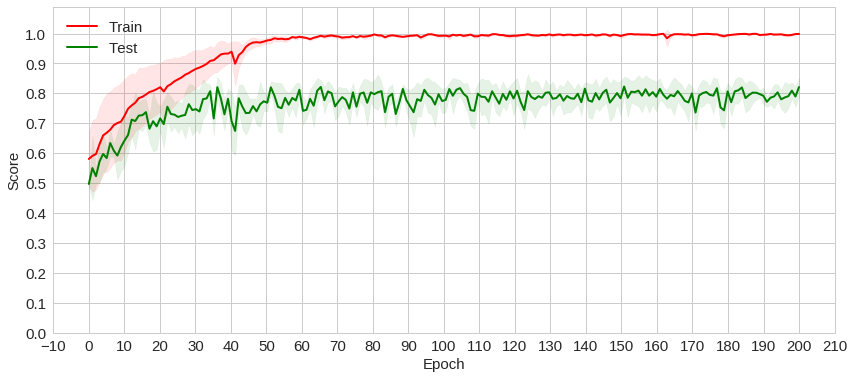

In [26]:
plot_mean_acc(history)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-0.9,10.9))
    plt.show()

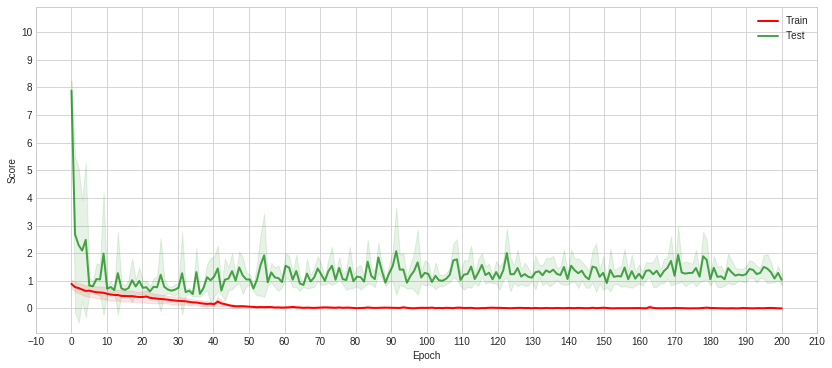

In [3]:
plot_mean_loss(history)